# 3. Spatial Interaction Models


In [1]:
# import all the necessary libraries
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import expit  
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
from math import sqrt
import statsmodels.formula.api as smf
from scipy.stats import norm

## 3. models:

| Models             | Formula                                                                                     | Definition                                                                                                                                                                                    |
|--------------------|---------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Gravity            | $$ T_{ij} = kO_i^\alpha D_j^\gamma d_{ij}^{-\beta} $$                                       | Predicts interaction flow from origin i to destination j , based on 'mass' of origin and destination, and the distance/cost between them.                                          |
| Unconstrained      | $$ T_{ij} = kO_i^\alpha D_j^\gamma d_{ij}^{-\beta} $$                                      | Similar to the Gravity Model without any additional constraints, this framework allows for interactions or flows between spatial units without limitations.                                    |
| Singly Constrained | Origin-Constrained: $$ T_{ij} = A_i O_i D_j d_{ij}^{-\beta} $$ Destination-Constrained: $$ T_{ij} = O_i B_j D_j d_{ij}^{-\beta} $$ | Includes a constraint on either the supply side (origin) or demand side (destination). The flow from each origin or to each destination sums to a known total. Balancing factors $$ A_i $$ or $$ B_j $$ are introduced. |
| Doubly Constrained | $$ T_{ij} = A_i B_j O_i D_j d_{ij}^{-\beta} $$   $$A_i = \frac{1}{\sum\limits_{j} B_j D_j d_{ij}^{-\beta}} $$ $$\quad B_j = \frac{1}{\sum\limits_{i} A_i O_i d_{ij}^{-\beta}}$$        | Extends the Singly Constrained model by incorporating both origin and destination constraints. It ensures the total outflow from each origin and the total inflow to each destination match known totals.                 |


## 3.2 Model Parameter Calibration
use single constrained model.

In [2]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [21]:
london_flow_df = pd.read_csv('london_flows.csv')

clear 0s

In [22]:
for column in ['population', 'jobs', 'distance']:
    london_flow_df = london_flow_df[london_flow_df[column] != 0]

london_flow_df = london_flow_df.reset_index()

normalise the columns:

In [23]:
london_flow_df['population_log'] = np.log(london_flow_df['population'])
london_flow_df['jobs_log'] = np.log(london_flow_df['jobs'])
london_flow_df['distance_log'] = np.log(london_flow_df['distance'])

In [24]:
london_flow_df.to_csv('london_flows_processed.csv', index=False)

singly constrained model: (dest constrained)

In [143]:
sc_df = pd.read_csv('london_flows_processed.csv')
sc_df = sc_df.drop("index", axis=1)


In [28]:
sc_df.head()

,station_origin,station_destination,flows,population,jobs,distance,population_log,jobs_log,distance_log
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274


In [29]:
sc_dest_c_model = smf.glm(formula = 'flows ~ station_destination + jobs_log + distance_log-1', 
                    data=sc_df, family=sm.families.Poisson()).fit()



In [23]:
# store sc_model.summary() to pd.dataframe:
# summary_001 = sc_dest_c_model.summary()

# summary_001 = summary_001.tables[1]

# summary_001 = pd.DataFrame(data=summary_001.data[1:], columns=summary_001.data[0])

# summary_001 = summary_001.set_index(summary_001.columns[0])
# summary_001.to_csv('sc_model_summary_001.csv')

#.to_csv('sc_model_summary_001.csv')

In [10]:
print(sc_dest_c_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61014
Model Family:                 Poisson   Df Model:                          398
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7321e+06
Date:                Mon, 29 Apr 2024   Deviance:                   3.2919e+06
Time:                        10:10:57   Pearson chi2:                 7.04e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------


Our $$\beta$$ is


In [46]:
print('beta:', sc_dest_c_model.params[-1])

beta: -0.7211502022376352


/tmp/ipykernel_800/4180235667.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('beta:', sc_dest_c_model.params[-1])


In [45]:
print('alpha:',sc_dest_c_model.params[-3])


alpha: 0.8624028403974918


/tmp/ipykernel_800/57986387.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('alpha:',sc_dest_c_model.params[-3])


In [31]:
predict_sc = sc_dest_c_model.get_prediction(sc_df[["station_destination","jobs_log", "distance_log"]])
pred_summary = predict_sc.summary_frame()
sc_df["estimation_inv_power"] = round(pred_summary["mean"],0)

In [40]:
sc_df.head()

,station_origin,station_destination,flows,population,jobs,distance,population_log,jobs_log,distance_log,estimation_inv_power,est_nega_dis
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,238.0,311.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,9.0,10.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,13.0,17.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,291.0,408.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,153.0,159.0


In [59]:
R2 = CalcRSqaured(sc_df["flows"], sc_df["estimation_inv_power"])
RMSE = CalcRMSE(sc_df["flows"],sc_df["estimation_inv_power"])
print('Destination constrained model, inverse power')
print(f'R2={R2}, RMSE={RMSE}')

Destination constrained model, inverse power
R2=0.09212542401595983, RMSE=125.893


In [34]:

sc_dest_negexp = smf.glm(formula = 'flows ~ station_destination + jobs_log + distance -1', 
                             data=sc_df, family=sm.families.Poisson()).fit()
#print(ori_cosim_nega_dis.summary())

In [51]:
sc_dest_negexp.params[-3]

/tmp/ipykernel_800/2340947387.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sc_dest_negexp.params[-3]


1.2552147687493118

In [61]:
print('destination, beta ' ,sc_dest_negexp.params[-1])
print('destination, alpha ' ,sc_dest_negexp.params[-3])

destination, beta  -0.00011152961222158167
destination, alpha  1.2552147687493118


/tmp/ipykernel_800/2355287993.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('destination, beta ' ,sc_dest_negexp.params[-1])
/tmp/ipykernel_800/2355287993.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('destination, alpha ' ,sc_dest_negexp.params[-3])


In [37]:
# print(uncosim_nega_dis.summary())
predictions =sc_dest_negexp.get_prediction(sc_df[["station_destination", "jobs_log","distance"]])
predictions_summary_framep = predictions.summary_frame()
sc_df["est_nega_dis"] = round(predictions_summary_framep["mean"],0)

negative distance


In [58]:
R2 = CalcRSqaured(sc_df["flows"], sc_df["est_nega_dis"])
RMSE = CalcRMSE(sc_df["flows"], sc_df["est_nega_dis"])
print('Destinatioin constrained model, negative distance')
print(f'R2={R2}, RMSE={RMSE}')

Destinatioin constrained model, negative distance
R2=0.12852970484917214, RMSE=122.754


In [125]:
predictions = sc_dest_c_model.get_prediction(sc_df[["station_destination", "jobs_log", "distance_log"]])
predictions_summary_frame = predictions.summary_frame()
sc_df["attrsimFitted"] = round(predictions_summary_frame["mean"],0)
#now we can create pivot table to turn paired list into matrix (and compute the margins as well)
sc_df_mat= sc_df.pivot_table(values ="attrsimFitted", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
sc_df_mat

/tmp/ipykernel_800/4095326722.py:5: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  sc_df_mat= sc_df.pivot_table(values ="attrsimFitted", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/4095326722.py:5: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  sc_df_mat= sc_df.pivot_table(values ="attrsimFitted", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/4095326722.py:5: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used dir

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.0,2503.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,1258.0
Acton Town,NaN,NaN,NaN,20.0,19.0,NaN,10.0,2.0,NaN,20.0,...,29.0,4.0,6.0,11.0,NaN,2.0,NaN,3.0,NaN,4039.0
Aldgate,NaN,NaN,7.0,NaN,115.0,NaN,NaN,1.0,NaN,59.0,...,25.0,NaN,10.0,7.0,NaN,4.0,NaN,4.0,NaN,8886.0
Aldgate East,NaN,NaN,7.0,119.0,NaN,NaN,3.0,1.0,NaN,56.0,...,25.0,3.0,10.0,7.0,NaN,4.0,NaN,4.0,NaN,8657.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,5.0,21.0,22.0,NaN,NaN,NaN,NaN,18.0,...,17.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3121.0
Woodgrange Park,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,566.0
Woodside Park,NaN,NaN,5.0,20.0,19.0,NaN,3.0,NaN,NaN,21.0,...,19.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3085.0


In [79]:
sc_df.to_csv('sc_df.csv', index=False)

In [67]:

from scipy.optimize import minimize


def decay_function(distance, b):
    return np.exp(-b * distance)

# We'll use an optimization routine to find the best-fitting 'b'
def calibrate_b(df):
    # Define the objective function that we want to minimize (negative log-likelihood)
    def objective(b):
        # Calculate the expected flows using the decay function
        expected_flows = df['population'] * df['jobs'] * decay_function(df['distance'], b)
        # Avoid dividing by zero
        expected_flows[expected_flows == 0] = 1e-5
        # Calculate the log-likelihood
        log_likelihood = -np.sum(df['flows'] * np.log(expected_flows) - expected_flows)
        return log_likelihood

    # Initial guess
    b0 = 0.1
    # Perform the minimization
    result = minimize(objective, -b0, method='L-BFGS-B', bounds=[(0.001, None)])
    return result.x[0]


# Calibrate the 'b' parameter
b_calibrated = calibrate_b(sc_df)
print(f"Calibrated b parameter: {b_calibrated}")

# Now let's add the estimated flows to the dataframe using the calibrated b
sc_df['estimated_flows'] = sc_df['population'] * sc_df['jobs'] * decay_function(sc_df['distance'], b_calibrated)

# Select only the relevant columns for a clear output
output_columns = ['station_origin', 'station_destination', 'flows', 'estimated_flows']
result_df = sc_df[output_columns]

Calibrated b parameter: 0.3331951961667162


In [ ]:
result_df

In [ ]:
sc_df

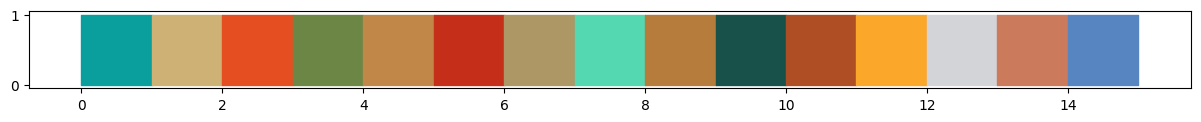

In [77]:
# Now import my favourite colour palette:
asteroid_city_col = ["#0A9F9D", "#CEB175", "#E54E21", "#6C8645", "#C18748", 
                     "#C52E19", "#AC9765", "#54D8B1", "#b67c3b", "#175149", 
                     "#AF4E24", "#FBA72A", "#D3D4D8", "#CB7A5C", "#5785C1"]

# Now let's plot color pallette
plt.figure(figsize=(15, 1))
for i, color in enumerate(asteroid_city_col):
    plt.fill_between([i, i + 1], 0, 1, color=color)

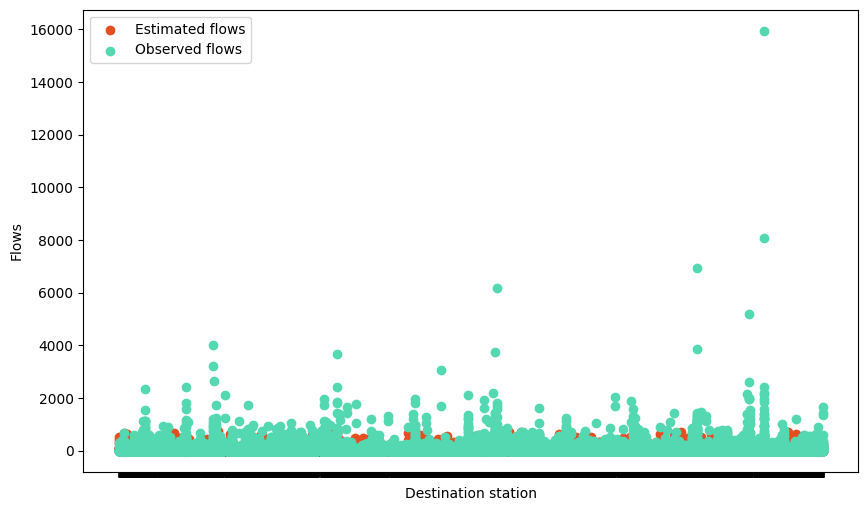

In [78]:
# plot sc_df: est_nega_dis and flows, x axis is station_destination:
plt.figure(figsize=(10, 6))
plt.scatter(sc_df["station_origin"], sc_df["est_nega_dis"], label="Estimated flows",color = asteroid_city_col[2])
plt.scatter(sc_df["station_origin"], sc_df["flows"], label="Observed flows",color = asteroid_city_col[7])
# Hide the value labels on the x-axis
plt.xticks(sc_df["station_origin"], [''] * len(sc_df["station_origin"]))
plt.xlabel("Destination station")
plt.ylabel("Flows")
plt.legend()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(sc_df["station_origin"], sc_df["est_nega_dis"], label="Estimated flows")
plt.scatter(sc_df["station_origin"], sc_df["flows"], label="Observed flows")
# Hide the value labels on the x-axis
plt.xticks(x, [])
plt.xlabel("Destination station")
plt.ylabel("Flows")
plt.legend()

In [ ]:
R2 = CalcRSqaured(sc_df["flows"], sc_df["est_nega_dis"])
RMSE = CalcRMSE(sc_df["flows"], sc_df["est_nega_dis"])
print('Destinatioin constrained model, negative distance')
print(f'R2={R2}, RMSE={RMSE}')

Destinatioin constrained model, negative distance
R2=0.12852970484917214, RMSE=122.754


In [32]:
# Calibrate the 'b' parameter
b_calibrated = calibrate_b(sc_df)
print(f"Calibrated b parameter: {b_calibrated}")

# Now let's add the estimated flows to the dataframe using the calibrated b
sc_df['estimated_flows'] = sc_df['population'] * sc_df['jobs'] * decay_function(sc_df['distance'], b_calibrated)

# Select only the relevant columns for a clear output
output_columns = ['station_origin', 'station_destination', 'flows', 'estimated_flows']
result_df = sc_df[output_columns]

Calibrated b parameter: 0.09997902916113967


In [83]:
# we can do this by pulling out the parameter values.
coefs = pd.DataFrame(sc_dest_negexp.params)
coefs.reset_index(inplace=True)
coefs.head()

,index,0
0,station_destination[Abbey Road],-0.217760
1,station_destination[Acton Central],0.256476
2,station_destination[Acton Town],-0.402615
3,station_destination[Aldgate],-0.124027
4,station_destination[Aldgate East],-0.195461


In [ ]:
coefs.rename(columns={0: "alpha_i", "index": "coef"}, inplace=True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)
coefs
# then once you have done this you can join them back into the dataframes
file_network = file_network.merge(coefs, left_on="station_origin", right_on="coef", how="left")
file_network.drop(columns=["coef"], inplace=True)

## Scenario A

In [ ]:
# predictions = sc_dest_c_model.get_prediction(sc_df[["station_destination", "jobs_log", "distance_log"]])
# predictions_summary_frame = predictions.summary_frame()
# sc_df["attrsimFitted"] = round(predictions_summary_frame["mean"],0)
# #now we can create pivot table to turn paired list into matrix (and compute the margins as well)
# sc_df_mat= sc_df.pivot_table(values ="attrsimFitted", index="station_origin", columns = "station_destination",
#                                     aggfunc=np.sum, margins=True)
# sc_df_mat

In [81]:
canary_wharf_index = sc_df[sc_df['station_destination'] == 'Canary Wharf'].index
df_sc_dc_a.loc[canary_wharf_index, 'jobs'] *= 0.5

decrease canary wharf by 50%:

In [82]:
# make a copy of dataframe:
df_sc_dc_a = sc_df.copy()

# Apply a 50% reduction to the jobs at Canary Wharf
df_sc_dc_a.loc[canary_wharf_index, 'jobs'] *= 0.5


In [90]:
# cread column that is log of jobs:
df_sc_dc_a['jobs_log_A'] = np.log(df_sc_dc_a['jobs'])

our parameters:

destination, beta  -0.00011152961222158167

destination, alpha  1.2552147687493118

In [95]:

alpha = sc_dest_negexp.params[-3]
beta = -sc_dest_negexp.params[-1]

/tmp/ipykernel_800/3611018728.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = sc_dest_negexp.params[-3]
/tmp/ipykernel_800/3611018728.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -sc_dest_negexp.params[-1]


In [96]:
alpha

1.2552147687493118

In [97]:
scenaria_model_nobound = smf.glm(formula = 'flows ~ station_destination + jobs_log_A + distance_log -1', 
                         data=df_sc_dc_a, family=sm.families.Poisson()).fit()

In [ ]:
print(scenaria_model_nobound.summary())

In [94]:
print("beta", scenaria_model.params[-1])

print("alpha", scenaria_model.params[-3])

beta -0.7211502022376312
alpha 0.8584697840668296


/tmp/ipykernel_800/2602389156.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("beta", scenaria_model.params[-1])
/tmp/ipykernel_800/2602389156.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("alpha", scenaria_model.params[-3])


Constrains

In [106]:
#calculate some new wj^alpha and d_ij^beta values
Oj2_alpha = sc_df["jobs"]**alpha
dist_beta = np.exp(sc_df["distance"]*-beta)

#calcualte the first stag
sc_df["Bi1"] = Oj2_alpha * dist_beta

#now do the sum over all js bit
B_i = pd.DataFrame(sc_df.groupby(["station_destination"])["Bi1"].agg(np.sum))

#now divide into 1
B_i["Bi1"] = 1/B_i["Bi1"]
B_i.rename(columns={"Bi1":"B_i"}, inplace=True)

#and write the A_i values back into the dataframe
sc_df = sc_df.merge(B_i, left_on="station_destination", right_index=True, how="left")

/tmp/ipykernel_800/658684682.py:9: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  B_i = pd.DataFrame(sc_df.groupby(["station_destination"])["Bi1"].agg(np.sum))


In [129]:
#df_sc_dc_a

#calculate some new wj^alpha and d_ij^beta values
Oj2_alpha = df_sc_dc_a["jobs"]**alpha
dist_beta = np.exp(df_sc_dc_a["distance"]*-beta)

#calcualte the first stag
df_sc_dc_a["Bi1"] = Oj2_alpha * dist_beta

#now do the sum over all js bit
B_i = pd.DataFrame(df_sc_dc_a.groupby(["station_destination"])["Bi1"].agg(np.sum))

#now divide into 1
B_i["Bi1"] = 1/B_i["Bi1"]
B_i.rename(columns={"Bi1":"B_i"}, inplace=True)

#and write the A_i values back into the dataframe
df_sc_dc_a = df_sc_dc_a.merge(B_i, left_on="station_destination", right_index=True, how="left")

/tmp/ipykernel_800/2790422573.py:11: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  B_i = pd.DataFrame(df_sc_dc_a.groupby(["station_destination"])["Bi1"].agg(np.sum))


In [107]:
sc_df.head()

,station_origin,station_destination,flows,population,jobs,distance,population_log,jobs_log,distance_log,estimation_inv_power,est_nega_dis,estimated_flows,Bi1,B_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,238.0,311.0,0.000000e+00,563104.048582,7.025943e-09
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,9.0,10.0,0.000000e+00,809.787238,2.889154e-05
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,13.0,17.0,0.000000e+00,2292.857966,1.106424e-05
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,291.0,408.0,0.000000e+00,549489.337802,1.262075e-08
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,153.0,159.0,2.739507e-316,141015.363726,7.288776e-08


In [108]:
D_j = pd.DataFrame(sc_df.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
sc_df = sc_df.merge(D_j, on = "station_destination", how = "left" )

/tmp/ipykernel_800/1980445571.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  D_j = pd.DataFrame(sc_df.groupby(["station_destination"])["flows"].agg(np.sum))


In [109]:
sc_df.head()

,station_origin,station_destination,flows,population,jobs,distance,population_log,jobs_log,distance_log,estimation_inv_power,est_nega_dis,estimated_flows,Bi1,B_i,D_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,238.0,311.0,0.000000e+00,563104.048582,7.025943e-09,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,9.0,10.0,0.000000e+00,809.787238,2.889154e-05,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,13.0,17.0,0.000000e+00,2292.857966,1.106424e-05,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,291.0,408.0,0.000000e+00,549489.337802,1.262075e-08,58772
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,153.0,159.0,2.739507e-316,141015.363726,7.288776e-08,15428


In [116]:
#
sc_df["attrconstrained_beforeA"] = sc_df["B_i"]*sc_df["D_j"]*Oj2_alpha*dist_beta

#before_scenarioA[["attrconstrained_A", "est_nega_dis"]]

In [117]:
sc_df[["attrconstrained_beforeA", "est_nega_dis"]]

,attrconstrained_beforeA,est_nega_dis
0,310.766296,311.0
1,10.341031,10.0
2,16.870213,17.0
3,407.581792,408.0
4,158.573514,159.0
...,...,...
61408,38.487959,38.0
61409,27.922383,28.0
61410,5.437062,5.0
61411,22.397177,22.0


checked.

In [118]:
df_sc_dc_a

#calculate some new wj^alpha and d_ij^beta values
Oj2_alpha = df_sc_dc_a["jobs"]**alpha
dist_beta = np.exp(df_sc_dc_a["distance"]*-beta)

#calcualte the first stag
df_sc_dc_a["Bi1"] = Oj2_alpha * dist_beta

#now do the sum over all js bit
B_i = pd.DataFrame(df_sc_dc_a.groupby(["station_destination"])["Bi1"].agg(np.sum))

#now divide into 1
B_i["Bi1"] = 1/B_i["Bi1"]
B_i.rename(columns={"Bi1":"B_i"}, inplace=True)

#and write the A_i values back into the dataframe
df_sc_dc_a = df_sc_dc_a.merge(B_i, left_on="station_destination", right_index=True, how="left")

/tmp/ipykernel_800/269897791.py:11: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  B_i = pd.DataFrame(df_sc_dc_a.groupby(["station_destination"])["Bi1"].agg(np.sum))


In [120]:
df_sc_dc_a.head()

,station_origin,station_destination,flows,population,jobs,distance,population_log,jobs_log,distance_log,estimation_inv_power,est_nega_dis,estimated_flows,jobs_log_A,Bi1,B_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,238.0,311.0,0.000000e+00,11.271478,563104.048582,7.025943e-09
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,9.0,10.0,0.000000e+00,6.091310,809.787238,2.889154e-05
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,13.0,17.0,0.000000e+00,6.499787,2292.857966,1.106424e-05
3,Abbey Road,Canary Wharf,1,599,29386,5086.514220,6.395262,10.981421,8.534348,291.0,408.0,0.000000e+00,10.288274,230198.226536,3.012606e-08
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,153.0,159.0,2.739507e-316,9.643939,141015.363726,7.288776e-08


In [121]:
D_j = pd.DataFrame(df_sc_dc_a.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
df_sc_dc_a = df_sc_dc_a.merge(D_j, on = "station_destination", how = "left" )

/tmp/ipykernel_800/1911027692.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  D_j = pd.DataFrame(df_sc_dc_a.groupby(["station_destination"])["flows"].agg(np.sum))


In [122]:
df_sc_dc_a["attrconstrained_afterA"] = df_sc_dc_a["B_i"]*df_sc_dc_a["D_j"]*Oj2_alpha*dist_beta

In [124]:
df_sc_dc_a[["attrconstrained_afterA", "est_nega_dis",'flows']]

,attrconstrained_afterA,est_nega_dis,flows
0,310.766296,311.0,0
1,10.341031,10.0,1
2,16.870213,17.0,3
3,407.581792,408.0,1
4,158.573514,159.0,37
...,...,...,...
61408,38.487959,38.0,127
61409,27.922383,28.0,608
61410,5.437062,5.0,6
61411,22.397177,22.0,81


after mat

In [140]:
df_sc_dc_a["after_A"] = df_sc_dc_a["Bi1"]*df_sc_dc_a["D_j"]*Oj2_alpha*dist_beta
#round
df_sc_dc_a["after_A"] = round(df_sc_dc_a["after_A"])

In [141]:
df_sc_dc_mat = df_sc_dc_a.pivot_table(values ="after_A", index="station_destination", columns = "station_origin",
                            aggfunc=np.sum, margins=True)

/tmp/ipykernel_800/1332390558.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_sc_dc_mat = df_sc_dc_a.pivot_table(values ="after_A", index="station_destination", columns = "station_origin",
/tmp/ipykernel_800/1332390558.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_sc_dc_mat = df_sc_dc_a.pivot_table(values ="after_A", index="station_destination", columns = "station_origin",
/tmp/ipykernel_800/1332390558.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be us

In [142]:
df_sc_dc_mat

station_origin,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_destination,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.033191e+08,9.510033e+09
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.201228e+07,NaN,NaN,8.849868e+10
Acton Town,NaN,NaN,NaN,1.239644e+10,1.174489e+10,NaN,1.790461e+11,1.277246e+08,NaN,1.612929e+10,...,1.640752e+10,2.373870e+10,3.181236e+09,1.317613e+11,NaN,4.791593e+08,NaN,1.604336e+09,NaN,1.072929e+13
Aldgate,NaN,NaN,1.042255e+12,NaN,3.313223e+13,NaN,NaN,1.894337e+09,NaN,2.076849e+13,...,6.471283e+11,NaN,2.721953e+12,2.860291e+12,NaN,1.346656e+12,NaN,9.523462e+11,NaN,1.535480e+15
Aldgate East,NaN,NaN,1.055924e+12,3.542887e+13,NaN,NaN,3.482352e+11,1.918439e+09,NaN,2.103273e+13,...,6.556154e+11,9.485560e+11,2.756584e+12,2.896683e+12,NaN,1.983875e+12,NaN,9.644629e+11,NaN,1.744424e+15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,8.836564e+06,2.953816e+08,4.069437e+08,NaN,NaN,NaN,NaN,1.811280e+08,...,5.486559e+06,NaN,6.905371e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.498815e+10
Woodgrange Park,NaN,6.037160e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.752787e+08
Woodside Park,NaN,NaN,3.573327e+07,2.522874e+08,2.389349e+08,NaN,NaN,NaN,NaN,4.928494e+08,...,2.218653e+07,NaN,9.720641e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.184500e+10


before mat:

In [133]:
sc_df.head()

,station_origin,station_destination,flows,population,jobs,distance,population_log,jobs_log,distance_log,estimation_inv_power,est_nega_dis,estimated_flows,Bi1,B_i,D_j,attrconstrained_A,attrconstrained__beforeA,attrconstrained_beforeA,attrsimFitted
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,238.0,311.0,0.000000e+00,563104.048582,7.025943e-09,78549,310.766296,310.766296,310.766296,238.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,9.0,10.0,0.000000e+00,809.787238,2.889154e-05,442,10.341031,10.341031,10.341031,9.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,13.0,17.0,0.000000e+00,2292.857966,1.106424e-05,665,16.870213,16.870213,16.870213,13.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,291.0,408.0,0.000000e+00,549489.337802,1.262075e-08,58772,407.581792,407.581792,407.581792,291.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,153.0,159.0,2.739507e-316,141015.363726,7.288776e-08,15428,158.573514,158.573514,158.573514,153.0


In [135]:
sc_df["before_A"] = sc_df["Bi1"]*sc_df["D_j"]*Oj2_alpha*dist_beta



sc_df["before_A"] = round(sc_df["before_A"])

In [137]:
sc_df = sc_df.pivot_table(values ="before_A", index="station_destination", columns = "station_origin",
                            aggfunc=np.sum, margins=True)

KeyError: 'before_A'

,station_origin,station_destination,flows,population,jobs,distance,population_log,jobs_log,distance_log
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274


In [ ]:
# To conserve the total number of commuters, we must scale the new estimated flows
total_original_flows = df_sc_dc_a['flows'].sum()
total_new_estimated_flows = df_sc_dc_a['new_estimated_flows'].sum()

# Scaling factor to ensure the number of commuters is conserved
scaling_factor = total_original_flows / total_new_estimated_flows
df_sc_dc_a['scaled_new_estimated_flows'] = df_sc_dc_a['new_estimated_flows'] * scaling_factor

# Select only the relevant columns for a clear output
output_columns += ['new_estimated_flows', 'scaled_new_estimated_flows']
result_df = df_sc_dc_a[output_columns]


In [ ]:
canary_wharf_index = sc_df[sc_df['station_destination'] == 'Canary Wharf'].index
df_sc_dc_a.loc[canary_wharf_index, 'jobs'] *= 0.5

In [149]:
sc_df.head()

,station_origin,station_destination,flows,population,jobs,distance,population_log,jobs_log,distance_log
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274


In [152]:
sc_dest_negexp = smf.glm(formula = 'flows ~ station_destination + jobs_log + distance -1', 
                             data=sc_df, family=sm.families.Poisson()).fit()

In [186]:
predictions = sc_dest_negexp.get_prediction(sc_df[["station_destination", "jobs_log", "distance"]])
predictions_summary_frame = predictions.summary_frame()
sc_df["attrsimFitted"] = round(predictions_summary_frame["mean"],0)
#now we can create pivot table to turn paired list into matrix (and compute the margins as well)
cdatasubmat6 = sc_df.pivot_table(values ="attrsimFitted", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
cdatasubmat6

/tmp/ipykernel_800/363251004.py:5: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat6 = sc_df.pivot_table(values ="attrsimFitted", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/363251004.py:5: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat6 = sc_df.pivot_table(values ="attrsimFitted", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/363251004.py:5: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be use

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.0,2459.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1142.0
Acton Town,NaN,NaN,NaN,16.0,15.0,NaN,14.0,1.0,NaN,16.0,...,35.0,4.0,4.0,15.0,NaN,1.0,NaN,2.0,NaN,4022.0
Aldgate,NaN,NaN,6.0,NaN,87.0,NaN,NaN,0.0,NaN,64.0,...,24.0,NaN,12.0,8.0,NaN,4.0,NaN,4.0,NaN,8843.0
Aldgate East,NaN,NaN,6.0,93.0,NaN,NaN,2.0,0.0,NaN,63.0,...,23.0,3.0,12.0,8.0,NaN,5.0,NaN,4.0,NaN,8981.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,19.0,21.0,NaN,NaN,NaN,NaN,13.0,...,5.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2462.0
Woodgrange Park,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,549.0
Woodside Park,NaN,NaN,2.0,16.0,14.0,NaN,1.0,NaN,NaN,19.0,...,9.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,2450.0


## Scenario A fixed

In [150]:
def new_job(row):
    if row["station_destination"] == 'Canary Wharf':
        val = row["jobs"]*0.5
    else:
        val = row["jobs"]
    return val

sc_df["new_jobs_scenariA"]=sc_df.apply(new_job, axis=1)

In [168]:
coefs = pd.DataFrame(sc_dest_negexp.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"gamma_j", "index":"coef"}, inplace = True)

In [171]:
coefs.head()

,coef,gamma_j
0,Abbey Road,-0.217760
1,Acton Central,0.256476
2,Acton Town,-0.402615
3,Aldgate,-0.124027
4,Aldgate East,-0.195461


In [170]:
to_repl = ["station_destination", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)

In [172]:
  
#then once you have done this you can join them back into the dataframes
sc_df = sc_df.merge(coefs, left_on="station_destination", right_on="coef", how = "left")
sc_df.drop(columns = ["coef"], inplace = True)
#check this has worked
sc_df.head()

,station_origin,station_destination,flows,population,jobs,distance,population_log,jobs_log,distance_log,new_jobs_scenariA,gamma_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,78549.0,0.592543
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,442.0,0.013882
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,665.0,-0.244119
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,29386.0,0.679912
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,15428.0,0.135483


In [173]:
gamma_j= sc_dest_negexp.params[0:7]
alpha = sc_dest_negexp.params[7]
beta = -sc_dest_negexp.params[8]

/tmp/ipykernel_800/2000874730.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = sc_dest_negexp.params[7]
/tmp/ipykernel_800/2000874730.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -sc_dest_negexp.params[8]


In [174]:
#create estimate for attrsimest2
#using the calculated gamma_j and alpha and beta values
#remember to log the new origin population
sc_df["attrsimest2"] = np.exp(sc_df["gamma_j"]+alpha*np.log(sc_df["new_jobs_scenariA"]) - beta*sc_df["distance_log"])

#round these to integer values
#as we don't want half a person
sc_df["attrsimest2"] = round(sc_df["attrsimest2"],0)

#now we can convert the pivot table into a matrix
#called cdatasubmat7
cdatasubmat7 = sc_df.pivot_table(values ="attrsimest2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

#display the results
cdatasubmat7

/tmp/ipykernel_800/1241416487.py:12: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat7 = sc_df.pivot_table(values ="attrsimest2", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/1241416487.py:12: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat7 = sc_df.pivot_table(values ="attrsimest2", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/1241416487.py:12: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be u

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334811.0,6.984627e+06
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10838.0,NaN,NaN,8.901896e+06
Acton Town,NaN,NaN,NaN,181707.0,173289.0,NaN,8913.0,22385.0,NaN,159338.0,...,294594.0,8729.0,49520.0,17447.0,NaN,16378.0,NaN,18727.0,NaN,3.959088e+07
Aldgate,NaN,NaN,37830.0,NaN,79158.0,NaN,NaN,23759.0,NaN,99351.0,...,313380.0,NaN,40970.0,21564.0,NaN,13167.0,NaN,16459.0,NaN,2.839440e+07
Aldgate East,NaN,NaN,38000.0,83376.0,NaN,NaN,14285.0,23800.0,NaN,101467.0,...,314630.0,9388.0,41217.0,21696.0,NaN,12777.0,NaN,16532.0,NaN,2.861072e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,46023.0,177725.0,163730.0,NaN,NaN,NaN,NaN,166117.0,...,374899.0,NaN,49018.0,NaN,NaN,NaN,NaN,NaN,NaN,4.165564e+07
Woodgrange Park,NaN,28070.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.244443e+06
Woodside Park,NaN,NaN,43363.0,183065.0,174572.0,NaN,15895.0,NaN,NaN,154668.0,...,354698.0,NaN,48537.0,NaN,NaN,NaN,NaN,NaN,NaN,4.087118e+07


In [175]:
#calculate some new Oi^alpha and d_ij^beta values
#called oi2_alpha and dist_beta
Oi2_alpha = sc_df["jobs"]**alpha
dist_beta = sc_df["distance"]**-beta

#calcualte the first stage of the Bj values
sc_df["Bj1"] = Oi2_alpha * dist_beta

#now do the sum over all is bit
B_j = pd.DataFrame(sc_df.groupby(["station_destination"])["Bj1"].agg(np.sum))

#now divide into 1
B_j["Bj1"] = 1/B_j["Bj1"]

#rename the column from Bj1 to B_j
B_j.rename(columns={"Bj1":"B_j2"}, inplace=True)
#and write the B_j values back into the dataframe
sc_df = sc_df.merge(B_j, left_on="station_destination", right_index=True, how="left")

/tmp/ipykernel_800/3554247330.py:10: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  B_j = pd.DataFrame(sc_df.groupby(["station_destination"])["Bj1"].agg(np.sum))


In [176]:
sc_df.head()

,station_origin,station_destination,flows,population,jobs,distance,population_log,jobs_log,distance_log,new_jobs_scenariA,gamma_j,attrsimest2,Bj1,B_j2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,78549.0,0.592543,3136491.0,1.734226e+06,1.742435e-09
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,442.0,0.013882,8939.0,8.815929e+03,2.624177e-06
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,665.0,-0.244119,8113.0,1.035646e+04,2.539660e-06
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,29386.0,0.679912,1080208.0,1.111716e+06,2.176715e-09
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,15428.0,0.135483,249949.0,2.182792e+05,8.385590e-09


In [178]:
D_j = pd.DataFrame(sc_df.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows_y":"D_j"}, inplace = True)
sc_df = sc_df.merge(D_j, on = "station_destination", how = "left" )

/tmp/ipykernel_800/373222597.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  D_j = pd.DataFrame(sc_df.groupby(["station_destination"])["flows"].agg(np.sum))


In [181]:
sc_df.rename(columns={"flows_y":"D_j"}, inplace = True)

In [182]:
sc_df.head()

,station_origin,station_destination,flows_x,population,jobs,distance,population_log,jobs_log,distance_log,new_jobs_scenariA,gamma_j,attrsimest2,Bj1,B_j2,D_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,78549.0,0.592543,3136491.0,1.734226e+06,1.742435e-09,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,442.0,0.013882,8939.0,8.815929e+03,2.624177e-06,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,665.0,-0.244119,8113.0,1.035646e+04,2.539660e-06,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,29386.0,0.679912,1080208.0,1.111716e+06,2.176715e-09,58772
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,15428.0,0.135483,249949.0,2.182792e+05,8.385590e-09,15428


In [187]:
sc_df["attrsimest3"] = sc_df["B_j2"]*sc_df["D_j"]*Oi2_alpha * dist_beta

#round
sc_df["attrsimest3"] = round(sc_df["attrsimest3"])
#check the head of the results
sc_df[["attrsimFitted","attrsimest2"]].head()

,attrsimFitted,attrsimest2
0,311.0,3136491.0
1,10.0,8939.0
2,17.0,8113.0
3,408.0,1080208.0
4,159.0,249949.0


In [188]:
Oi3_alpha = sc_df["new_jobs_scenariA"]**alpha

#calculate the first stage of the Bj values
sc_df["Bj1"] = Oi3_alpha * dist_beta
#now do the sum over all is bit
B_j = pd.DataFrame(sc_df.groupby(["station_destination"])["Bj1"].agg(np.sum))
#now divide into 1
B_j["Bj1"] = 1/B_j["Bj1"]
#rename the column
B_j.rename(columns={"Bj1":"Bj2"}, inplace=True)
#and write the B_j values back into the dataframe
sc_df = sc_df.merge(B_j, left_on="station_destination", right_index=True, how="left")

/tmp/ipykernel_800/966437929.py:6: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  B_j = pd.DataFrame(sc_df.groupby(["station_destination"])["Bj1"].agg(np.sum))


In [189]:
#to check everything works create the estimates for attrsimest4
sc_df["attrsimest4"] = sc_df["Bj2"]*sc_df["D_j"]*Oi3_alpha * dist_beta
#round to integer values
sc_df["attrsimest4"] = round(sc_df["attrsimest4"])

In [190]:
cdatasubmat8 = sc_df.pivot_table(values ="attrsimest4", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

#show the matrix
cdatasubmat8

/tmp/ipykernel_800/3102443656.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat8 = sc_df.pivot_table(values ="attrsimest4", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/3102443656.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat8 = sc_df.pivot_table(values ="attrsimest4", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/3102443656.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.0,1477.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,1728.0
Acton Town,NaN,NaN,NaN,37.0,36.0,NaN,3.0,2.0,NaN,34.0,...,24.0,3.0,9.0,7.0,NaN,4.0,NaN,5.0,NaN,5428.0
Aldgate,NaN,NaN,10.0,NaN,16.0,NaN,NaN,2.0,NaN,21.0,...,26.0,NaN,8.0,9.0,NaN,3.0,NaN,4.0,NaN,4106.0
Aldgate East,NaN,NaN,10.0,17.0,NaN,NaN,5.0,2.0,NaN,22.0,...,26.0,4.0,8.0,9.0,NaN,3.0,NaN,4.0,NaN,4196.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,12.0,36.0,34.0,NaN,NaN,NaN,NaN,36.0,...,31.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,5900.0
Woodgrange Park,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,652.0
Woodside Park,NaN,NaN,11.0,37.0,36.0,NaN,5.0,NaN,NaN,33.0,...,29.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,5556.0


In [194]:
sc_df.head()

,station_origin,station_destination,flows_x,population,jobs,distance,population_log,jobs_log,distance_log,new_jobs_scenariA,gamma_j,attrsimest2,Bj1,B_j2,D_j,attrsimest3,attrsimFitted,Bj2,attrsimest4
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,78549.0,0.592543,3136491.0,1.734226e+06,1.742435e-09,78549,237.0,311.0,1.742435e-09,237.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,442.0,0.013882,8939.0,8.815929e+03,2.624177e-06,442,10.0,10.0,2.624177e-06,10.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,665.0,-0.244119,8113.0,1.035646e+04,2.539660e-06,665,17.0,17.0,2.539660e-06,17.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,29386.0,0.679912,1080208.0,5.473002e+05,2.176715e-09,58772,142.0,408.0,4.421503e-09,142.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,15428.0,0.135483,249949.0,2.182792e+05,8.385590e-09,15428,28.0,159.0,8.385590e-09,28.0


In [195]:
cdatasubmat = pd.pivot_table(sc_df, values ="flows_x", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat

/tmp/ipykernel_800/3281914484.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat = pd.pivot_table(sc_df, values ="flows_x", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/3281914484.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat = pd.pivot_table(sc_df, values ="flows_x", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/3281914484.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used d

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [196]:
test_df = pd.read_csv('sc_df.csv')

In [197]:
cdatasubmat_test = pd.pivot_table(test_df, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat_test

/tmp/ipykernel_800/1405422631.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat_test = pd.pivot_table(test_df, values ="flows", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/1405422631.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat_test = pd.pivot_table(test_df, values ="flows", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/1405422631.py:1: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


cdatasubmat8: after job change.
cdatasubmat: before

In [198]:
# compare the two matrices:
diff = cdatasubmat8 - cdatasubmat
diff

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,878.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,504.0
Acton Town,NaN,NaN,NaN,34.0,19.0,NaN,-32.0,2.0,NaN,23.0,...,-53.0,0.0,3.0,-2.0,NaN,4.0,NaN,5.0,NaN,1683.0
Aldgate,NaN,NaN,10.0,NaN,16.0,NaN,NaN,2.0,NaN,4.0,...,26.0,NaN,4.0,1.0,NaN,3.0,NaN,4.0,NaN,1220.0
Aldgate East,NaN,NaN,8.0,17.0,NaN,NaN,5.0,2.0,NaN,2.0,...,2.0,4.0,8.0,-3.0,NaN,2.0,NaN,3.0,NaN,1024.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,10.0,31.0,-13.0,NaN,NaN,NaN,NaN,14.0,...,29.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,1032.0
Woodgrange Park,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.0
Woodside Park,NaN,NaN,10.0,11.0,25.0,NaN,5.0,NaN,NaN,-26.0,...,29.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,2463.0


In [199]:
sc_df['diff'] = sc_df['attrsimest4'] - sc_df['flows_x']

In [200]:
increase_flow = sc_df[sc_df['diff'] > 0]
decrease_flow = sc_df[sc_df['diff'] < 0]
unchange_flow = sc_df[sc_df['diff'] == 0]

In [212]:
increase_flow = sc_df[sc_df['diff'] > 0]
decrease_flow = sc_df[sc_df['diff'] < 0]
unchange_flow = sc_df[sc_df['diff'] == 0]
sc_df.shape[0]

61413

In [207]:
decrease_flow.shape[0]

12227

In [206]:
unchange_flow.shape[0]

1217

In [205]:
# numebr of rows of increase_flow :
increase_flow.shape[0]


47969

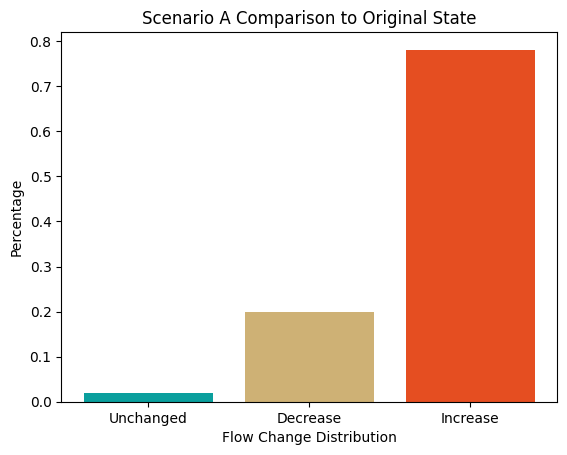

In [215]:
import pandas as pd
# barplot travel pairs with increase/unchange/decrease
import matplotlib.pyplot as plt

# Data
values = [unchange_flow.shape[0]/sc_df.shape[0], decrease_flow.shape[0]/sc_df.shape[0], increase_flow.shape[0]/sc_df.shape[0]]
labels = ['Unchanged', 'Decrease', 'Increase' ]


# Set the color for each bar
colors = [asteroid_city_col[0], asteroid_city_col[1], asteroid_city_col[2]]

# Plot the bar chart with customized colors
plt.bar(labels,values, color=colors)

# Add labels and title
plt.xlabel('Flow Change Distribution')
plt.ylabel('Percentage')
plt.title('Scenario A Comparison to Original State')

# Display the plot
plt.show()





In [217]:
increase_flow= increase_flow.sort_values(by='diff', ascending=False)

In [235]:
# Top 10 increase flows where destination is Canary Wharf:
increase_flow.head(20).to_csv('top10_increase_flows.csv')


In [231]:
decrease_flow= decrease_flow.sort_values(by='diff', ascending=True)

In [232]:
decrease_flow[decrease_flow["station_destination"] == "Canary Wharf"].head(10).to_csv('top10_decrease_flows.csv')

for increase: calc avg:

In [236]:
decrease_flow.head()

,station_origin,station_destination,flows_x,population,jobs,distance,population_log,jobs_log,distance_log,new_jobs_scenariA,gamma_j,attrsimest2,Bj1,B_j2,D_j,attrsimest3,attrsimFitted,Bj2,attrsimest4,diff
55890,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,11.117985,11.271478,7.841082,78549.0,0.592543,2173075.0,1.201535e+06,1.742435e-09,78549,164.0,580.0,1.742435e-09,164.0,-15782.0
55915,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,11.117985,10.981421,8.913817,29386.0,0.679912,1217680.0,6.169519e+05,2.176715e-09,58772,160.0,314.0,4.421503e-09,160.0,-7925.0
50041,Stratford,Liverpool Street,6946,59311,61122,6698.461270,10.990550,11.020627,8.809633,61122.0,0.558071,2205521.0,1.262246e+06,2.204172e-09,61122,170.0,308.0,2.204172e-09,170.0,-6776.0
32609,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,10.391976,10.981421,8.644567,29386.0,0.679912,1118455.0,5.666786e+05,2.176715e-09,58772,147.0,382.0,4.421503e-09,147.0,-6018.0
54769,Victoria,Oxford Circus,5181,37517,44368,2220.166284,10.532549,10.700274,7.705337,44368.0,0.379288,938047.0,6.419510e+05,3.663545e-09,44368,104.0,357.0,3.663545e-09,104.0,-5077.0


In [283]:
sc_df['log_diff'] = np.log(abs(sc_df['diff']/(abs(sc_df['flows_x'])+2.33))*100) - 5


/home/mengyuwsl/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


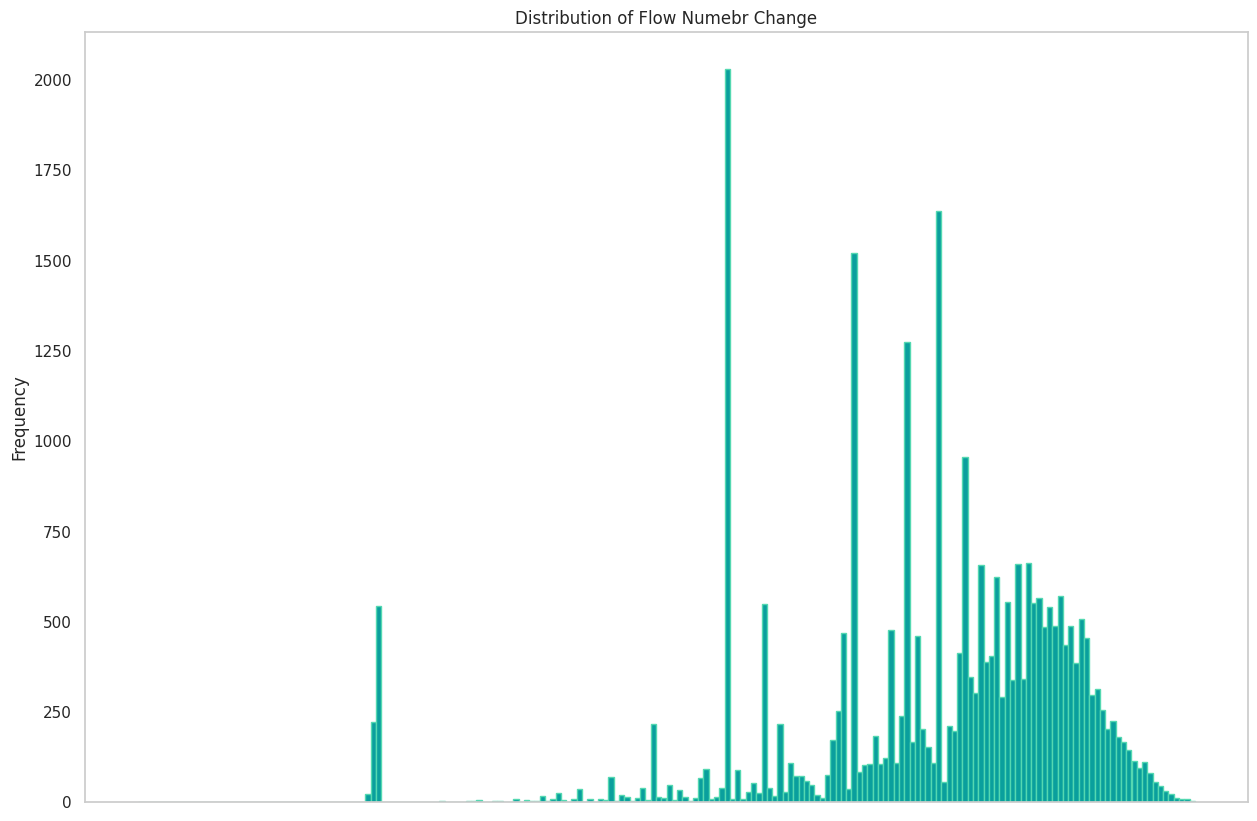

In [289]:
# plot sc_df['diff'], x as number of rows:

fig, ax = plt.subplots(figsize=(15, 10))


plt.hist(np.log(sc_df['log_diff']), bins=200, edgecolor=asteroid_city_col[7], color = asteroid_city_col[0] )  # Customize bins, edgecolor, etc. as needed

# Optionally, add labels and title
plt.xlabel('Value of Flow Number Change / Original Flow')
plt.ylabel('Frequency')
plt.title('Distribution of Flow Numebr Change')

# Display the plot
plt.show()

In [285]:
sc_df['abs_diff'] = abs(sc_df['diff'])

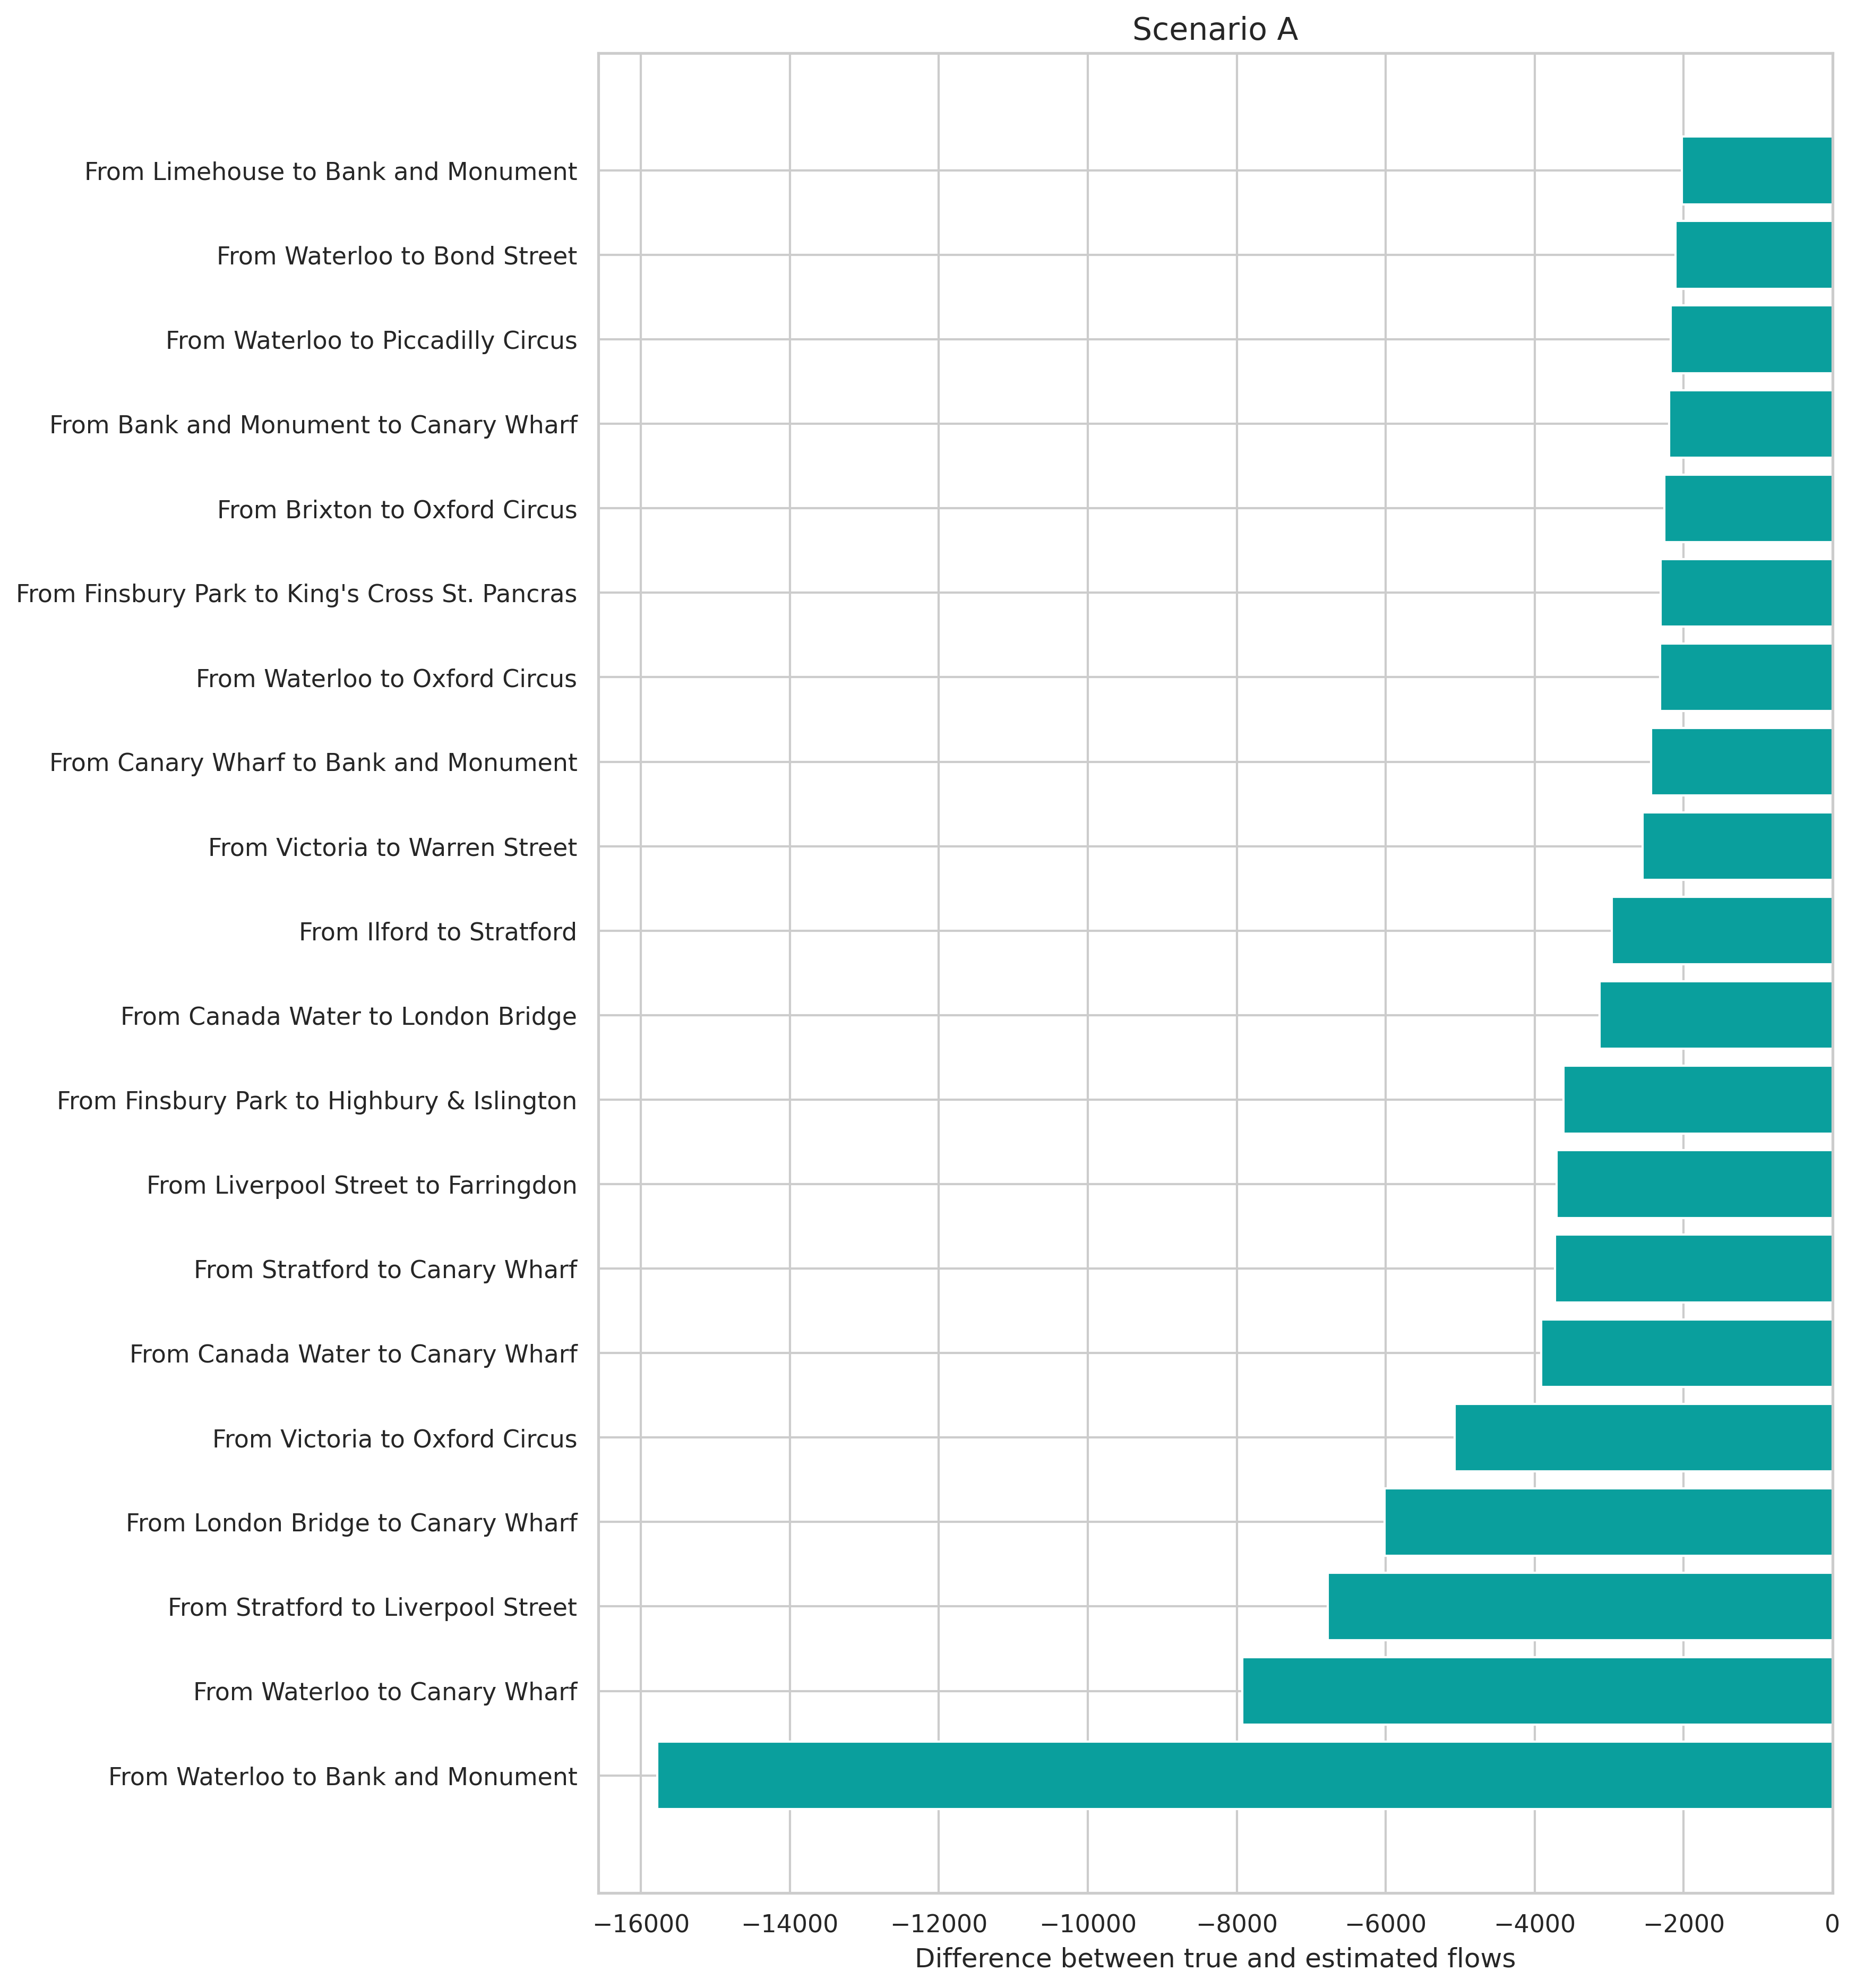

In [300]:
plt.figure(figsize=(10, 15), dpi=300)
sns.set_theme(style='whitegrid')

o_d_= []

sc_df_plot = sc_df.sort_values('abs_diff',ascending=False).reset_index()
sc_df_plot  = sc_df_plot.drop(columns='index')
for i in range(20):
    o_d_.append('From '+ sc_df_plot.iloc[i,0] + ' to ' + sc_df_plot.iloc[i,1])

plt.barh(o_d_, sc_df_plot.loc[:19,'diff'], color = asteroid_city_col[0])
#plt.vlines(0, 0, 28, colors = asteroid_city_col[11], linestyles = "dashed")
plt.title('Scenario A',fontsize=14)

# x label
plt.xlabel('Difference between true and estimated flows', fontsize=12)

# plt.savefig('Output/Figure_scenario_A.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your setup code
plt.figure(figsize=(10, 15), dpi=300)
sns.set_theme(style='whitegrid')

o_d_ = []
sc_df_plot = sc_df.sort_values('abs_diff', ascending=False).reset_index()
sc_df_plot = sc_df_plot.drop(columns='index')

# Generating your bar labels
for i in range(30):
    o_d_.append('From ' + sc_df_plot.iloc[i, 0] + ' to ' + sc_df_plot.iloc[i, 1])

plt.barh(o_d_, sc_df_plot.loc[:29, 'diff'], color=asteroid_city_col[0])

# Turn off gridlines for the current axis
plt.grid(False)  # This will turn off gridlines

plt.title('Scenario A', fontsize=14)
plt.xlabel('Difference between true and simulated flows', fontsize=12)

# If you want to save the figure
# plt.savefig('Output/Figure_scenario_A.png', dpi=300, bbox_inches='tight')

plt.show()


for decrease calc avg:

## Scenario B

In [303]:
beta_2 = beta * 2
beta_5 = beta * 5
beta_10 = beta * 10

In [312]:
Oi2_alpha_B2 = sc_df["jobs"]**alpha
dist_beta_B2 = sc_df["distance"]**-beta_2

#calcualte the first stage of the Bj values
sc_df["Bj1_B2"] = Oi2_alpha_B2 * dist_beta_B2

#now do the sum over all is bit
B_j_B2 = pd.DataFrame(sc_df.groupby(["station_destination"])["Bj1_B2"].agg(np.sum))

#now divide into 1
B_j_B2["Bj1_B2"] = 1/B_j_B2["Bj1_B2"]

#rename the column from Bj1 to B_j
B_j_B2.rename(columns={"Bj1":"B_j2_B2"}, inplace=True)
#and write the B_j values back into the dataframe
sc_df = sc_df.merge(B_j_B2, left_on="station_destination", right_index=True, how="left")

/tmp/ipykernel_800/3284762923.py:8: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  B_j_B2 = pd.DataFrame(sc_df.groupby(["station_destination"])["Bj1_B2"].agg(np.sum))


In [313]:
sc_df.head()

,station_origin,station_destination,flows_x,population,jobs,distance,population_log,jobs_log,distance_log,new_jobs_scenariA,...,attrsimest4,diff,log_diff,abs_diff,attrsimestB2,attrsimestB5,diff_B2,diff_B5,Bj1_B2_x,Bj1_B2_y
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,78549.0,...,237.0,237.0,4.227362,237.0,53806500.0,2.716482e+11,53806500.0,2.716482e+11,2.975065e+07,8.821104e-11
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,442.0,...,10.0,9.0,0.599422,9.0,155570.0,8.200045e+08,155569.0,8.200045e+08,1.534256e+05,1.469477e-07
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,665.0,...,17.0,14.0,0.570876,14.0,109243.0,2.666873e+08,109240.0,2.666873e+08,1.394485e+05,1.866759e-07
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,29386.0,...,142.0,141.0,3.350958,141.0,32459718.0,1.050876e+11,32459717.0,1.050876e+11,1.644610e+07,1.032311e-10
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,15428.0,...,28.0,-9.0,-1.869593,9.0,2849721.0,4.223312e+09,2849684.0,4.223312e+09,2.488643e+06,3.896866e-10


In [320]:
sc_df["attrsimestB2"]= sc_df["Bj1_B2_y"]*sc_df["D_j"]*Oi2_alpha_B2 * dist_beta_B2
#round to integer values
sc_df["attrsimestB2"] = round(sc_df["attrsimestB2"])

In [321]:
#sc_df["attrsimestB2"] = np.exp(sc_df["gamma_j"]+alpha*np.log(sc_df["jobs"]) - beta_2*sc_df["distance_log"])

#round these to integer values
#as we don't want half a person
#sc_df["attrsimestB2"] = round(sc_df["attrsimestB2"],0)

#now we can convert the pivot table into a matrix
#called cdatasubmat7
cdatasubmatB2 = sc_df.pivot_table(values ="attrsimestB2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

#display the results
cdatasubmatB2

/tmp/ipykernel_800/2561347044.py:9: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmatB2 = sc_df.pivot_table(values ="attrsimestB2", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/2561347044.py:9: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmatB2 = sc_df.pivot_table(values ="attrsimestB2", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/2561347044.py:9: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be 

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,1333.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,1873.0
Acton Town,NaN,NaN,NaN,39.0,39.0,NaN,2.0,2.0,NaN,36.0,...,22.0,3.0,10.0,5.0,NaN,5.0,NaN,5.0,NaN,5514.0
Aldgate,NaN,NaN,10.0,NaN,8.0,NaN,NaN,2.0,NaN,14.0,...,25.0,NaN,7.0,8.0,NaN,3.0,NaN,4.0,NaN,3235.0
Aldgate East,NaN,NaN,10.0,8.0,NaN,NaN,5.0,2.0,NaN,15.0,...,25.0,4.0,7.0,8.0,NaN,3.0,NaN,4.0,NaN,3323.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,15.0,37.0,34.0,NaN,NaN,NaN,NaN,39.0,...,35.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,6567.0
Woodgrange Park,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,693.0
Woodside Park,NaN,NaN,13.0,40.0,39.0,NaN,6.0,NaN,NaN,34.0,...,31.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,5998.0


In [322]:
Oi2_alpha_B5 = sc_df["jobs"]**alpha
dist_beta_B5 = sc_df["distance"]**-beta_5

#calcualte the first stage of the Bj values
sc_df["Bj1_B5"] = Oi2_alpha_B5 * dist_beta_B5

#now do the sum over all is bit
B_j_B5 = pd.DataFrame(sc_df.groupby(["station_destination"])["Bj1_B5"].agg(np.sum))

#now divide into 1
B_j_B5["Bj1_B5"] = 1/B_j_B5["Bj1_B5"]

#rename the column from Bj1 to B_j
B_j_B5.rename(columns={"Bj1":"B_j2_B5"}, inplace=True)
#and write the B_j values back into the dataframe
sc_df = sc_df.merge(B_j_B5, left_on="station_destination", right_index=True, how="left")

/tmp/ipykernel_800/62281148.py:8: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  B_j_B5 = pd.DataFrame(sc_df.groupby(["station_destination"])["Bj1_B5"].agg(np.sum))


In [323]:
sc_df.head()

,station_origin,station_destination,flows_x,population,jobs,distance,population_log,jobs_log,distance_log,new_jobs_scenariA,...,log_diff,abs_diff,attrsimestB2,attrsimestB5,diff_B2,diff_B5,Bj1_B2_x,Bj1_B2_y,Bj1_B5_x,Bj1_B5_y
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,78549.0,...,4.227362,237.0,206.0,2.716482e+11,53806500.0,2.716482e+11,2.975065e+07,8.821104e-11,1.501995e+11,9.094742e-15
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,442.0,...,0.599422,9.0,10.0,8.200045e+08,155569.0,8.200045e+08,1.534256e+05,1.469477e-07,8.087001e+08,2.383460e-11
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,665.0,...,0.570876,14.0,17.0,2.666873e+08,109240.0,2.666873e+08,1.394485e+05,1.866759e-07,3.404254e+08,6.362425e-11
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,29386.0,...,3.350958,141.0,100.0,1.050876e+11,32459717.0,1.050876e+11,1.644610e+07,1.032311e-10,5.324386e+10,9.017576e-15
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,15428.0,...,-1.869593,9.0,15.0,4.223312e+09,2849684.0,4.223312e+09,2.488643e+06,3.896866e-10,3.688192e+09,3.221560e-14


In [324]:
sc_df["attrsimestB5"]= sc_df["Bj1_B5_y"]*sc_df["D_j"]*Oi2_alpha_B5 * dist_beta_B5
#round to integer values
sc_df["attrsimestB5"] = round(sc_df["attrsimestB5"])

#now we can convert the pivot table into a matrix
#called cdatasubmat7
cdatasubmatB5 = sc_df.pivot_table(values ="attrsimestB5", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

#display the results
cdatasubmatB5

/tmp/ipykernel_800/3967744360.py:7: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmatB5 = sc_df.pivot_table(values ="attrsimestB5", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/3967744360.py:7: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmatB5 = sc_df.pivot_table(values ="attrsimestB5", index="station_origin", columns = "station_destination",
/tmp/ipykernel_800/3967744360.py:7: FutureWarning: The provided callable <function sum at 0x7f7b9c402dd0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be 

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0,1025.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,2202.0
Acton Town,NaN,NaN,NaN,38.0,40.0,NaN,1.0,2.0,NaN,35.0,...,15.0,3.0,11.0,2.0,NaN,6.0,NaN,7.0,NaN,4920.0
Aldgate,NaN,NaN,9.0,NaN,1.0,NaN,NaN,2.0,NaN,3.0,...,20.0,NaN,4.0,6.0,NaN,2.0,NaN,3.0,NaN,1611.0
Aldgate East,NaN,NaN,9.0,1.0,NaN,NaN,6.0,2.0,NaN,4.0,...,20.0,4.0,4.0,6.0,NaN,2.0,NaN,4.0,NaN,1668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,24.0,34.0,30.0,NaN,NaN,NaN,NaN,43.0,...,49.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,7681.0
Woodgrange Park,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,804.0
Woodside Park,NaN,NaN,18.0,39.0,42.0,NaN,9.0,NaN,NaN,30.0,...,37.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,6222.0


In [325]:
sc_df['diff_B2'] = sc_df['attrsimestB2'] - sc_df['flows_x']
sc_df['diff_B5'] = sc_df['attrsimestB5'] - sc_df['flows_x']

In [326]:
increase_flow_B2 = sc_df[sc_df['diff_B2'] > 0]
decrease_flow_B2 = sc_df[sc_df['diff_B2'] < 0]
unchange_flow_B2 = sc_df[sc_df['diff_B2'] == 0]
# sc_df.shape[0]

In [327]:
decrease_flow_B2.shape[0]

13047

In [328]:
increase_flow_B5 = sc_df[sc_df['diff_B5'] > 0]
decrease_flow_B5 = sc_df[sc_df['diff_B5'] < 0]
unchange_flow_B5 = sc_df[sc_df['diff_B5'] == 0]

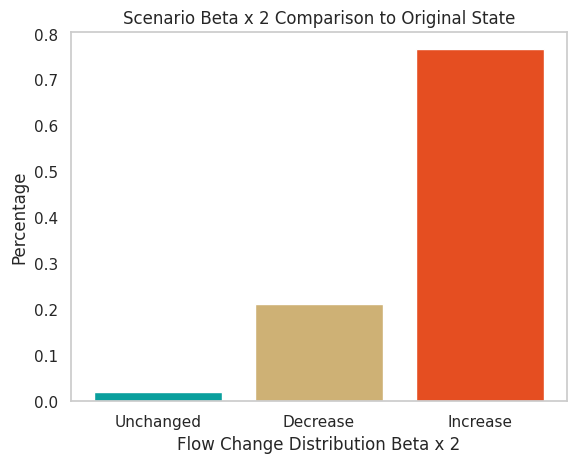

In [346]:
values = [unchange_flow_B2.shape[0]/sc_df.shape[0], decrease_flow_B2.shape[0]/sc_df.shape[0], increase_flow_B2.shape[0]/sc_df.shape[0]]
labels = ['Unchanged', 'Decrease', 'Increase' ]


# Set the color for each bar
colors = [asteroid_city_col[0], asteroid_city_col[1], asteroid_city_col[2]]

# Plot the bar chart with customized colors
plt.bar(labels,values, color=colors)

# Add labels and title
plt.xlabel('Flow Change Distribution Beta x 2')
plt.ylabel('Percentage')
plt.title('Scenario Beta x 2 Comparison to Original State')
plt.grid(False) 
# Display the plot
plt.show()


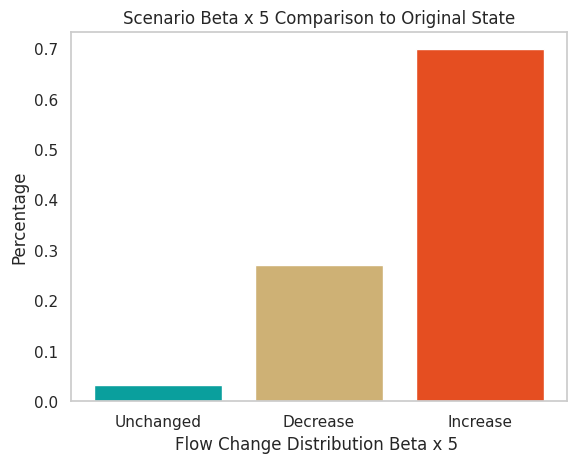

In [347]:
values = [unchange_flow_B5.shape[0]/sc_df.shape[0], decrease_flow_B5.shape[0]/sc_df.shape[0], increase_flow_B5.shape[0]/sc_df.shape[0]]
labels = ['Unchanged', 'Decrease', 'Increase' ]


# Set the color for each bar
colors = [asteroid_city_col[0], asteroid_city_col[1], asteroid_city_col[2]]

# Plot the bar chart with customized colors
plt.bar(labels,values, color=colors)

# Add labels and title
plt.xlabel('Flow Change Distribution Beta x 5 ')
plt.ylabel('Percentage')
plt.title('Scenario Beta x 5 Comparison to Original State')
plt.grid(False) 
# Display the plot
plt.show()


In [334]:
sc_df['abs_diff_B2'] = abs(sc_df['diff_B2'])
sc_df['abs_diff_B5'] = abs(sc_df['diff_B5'])

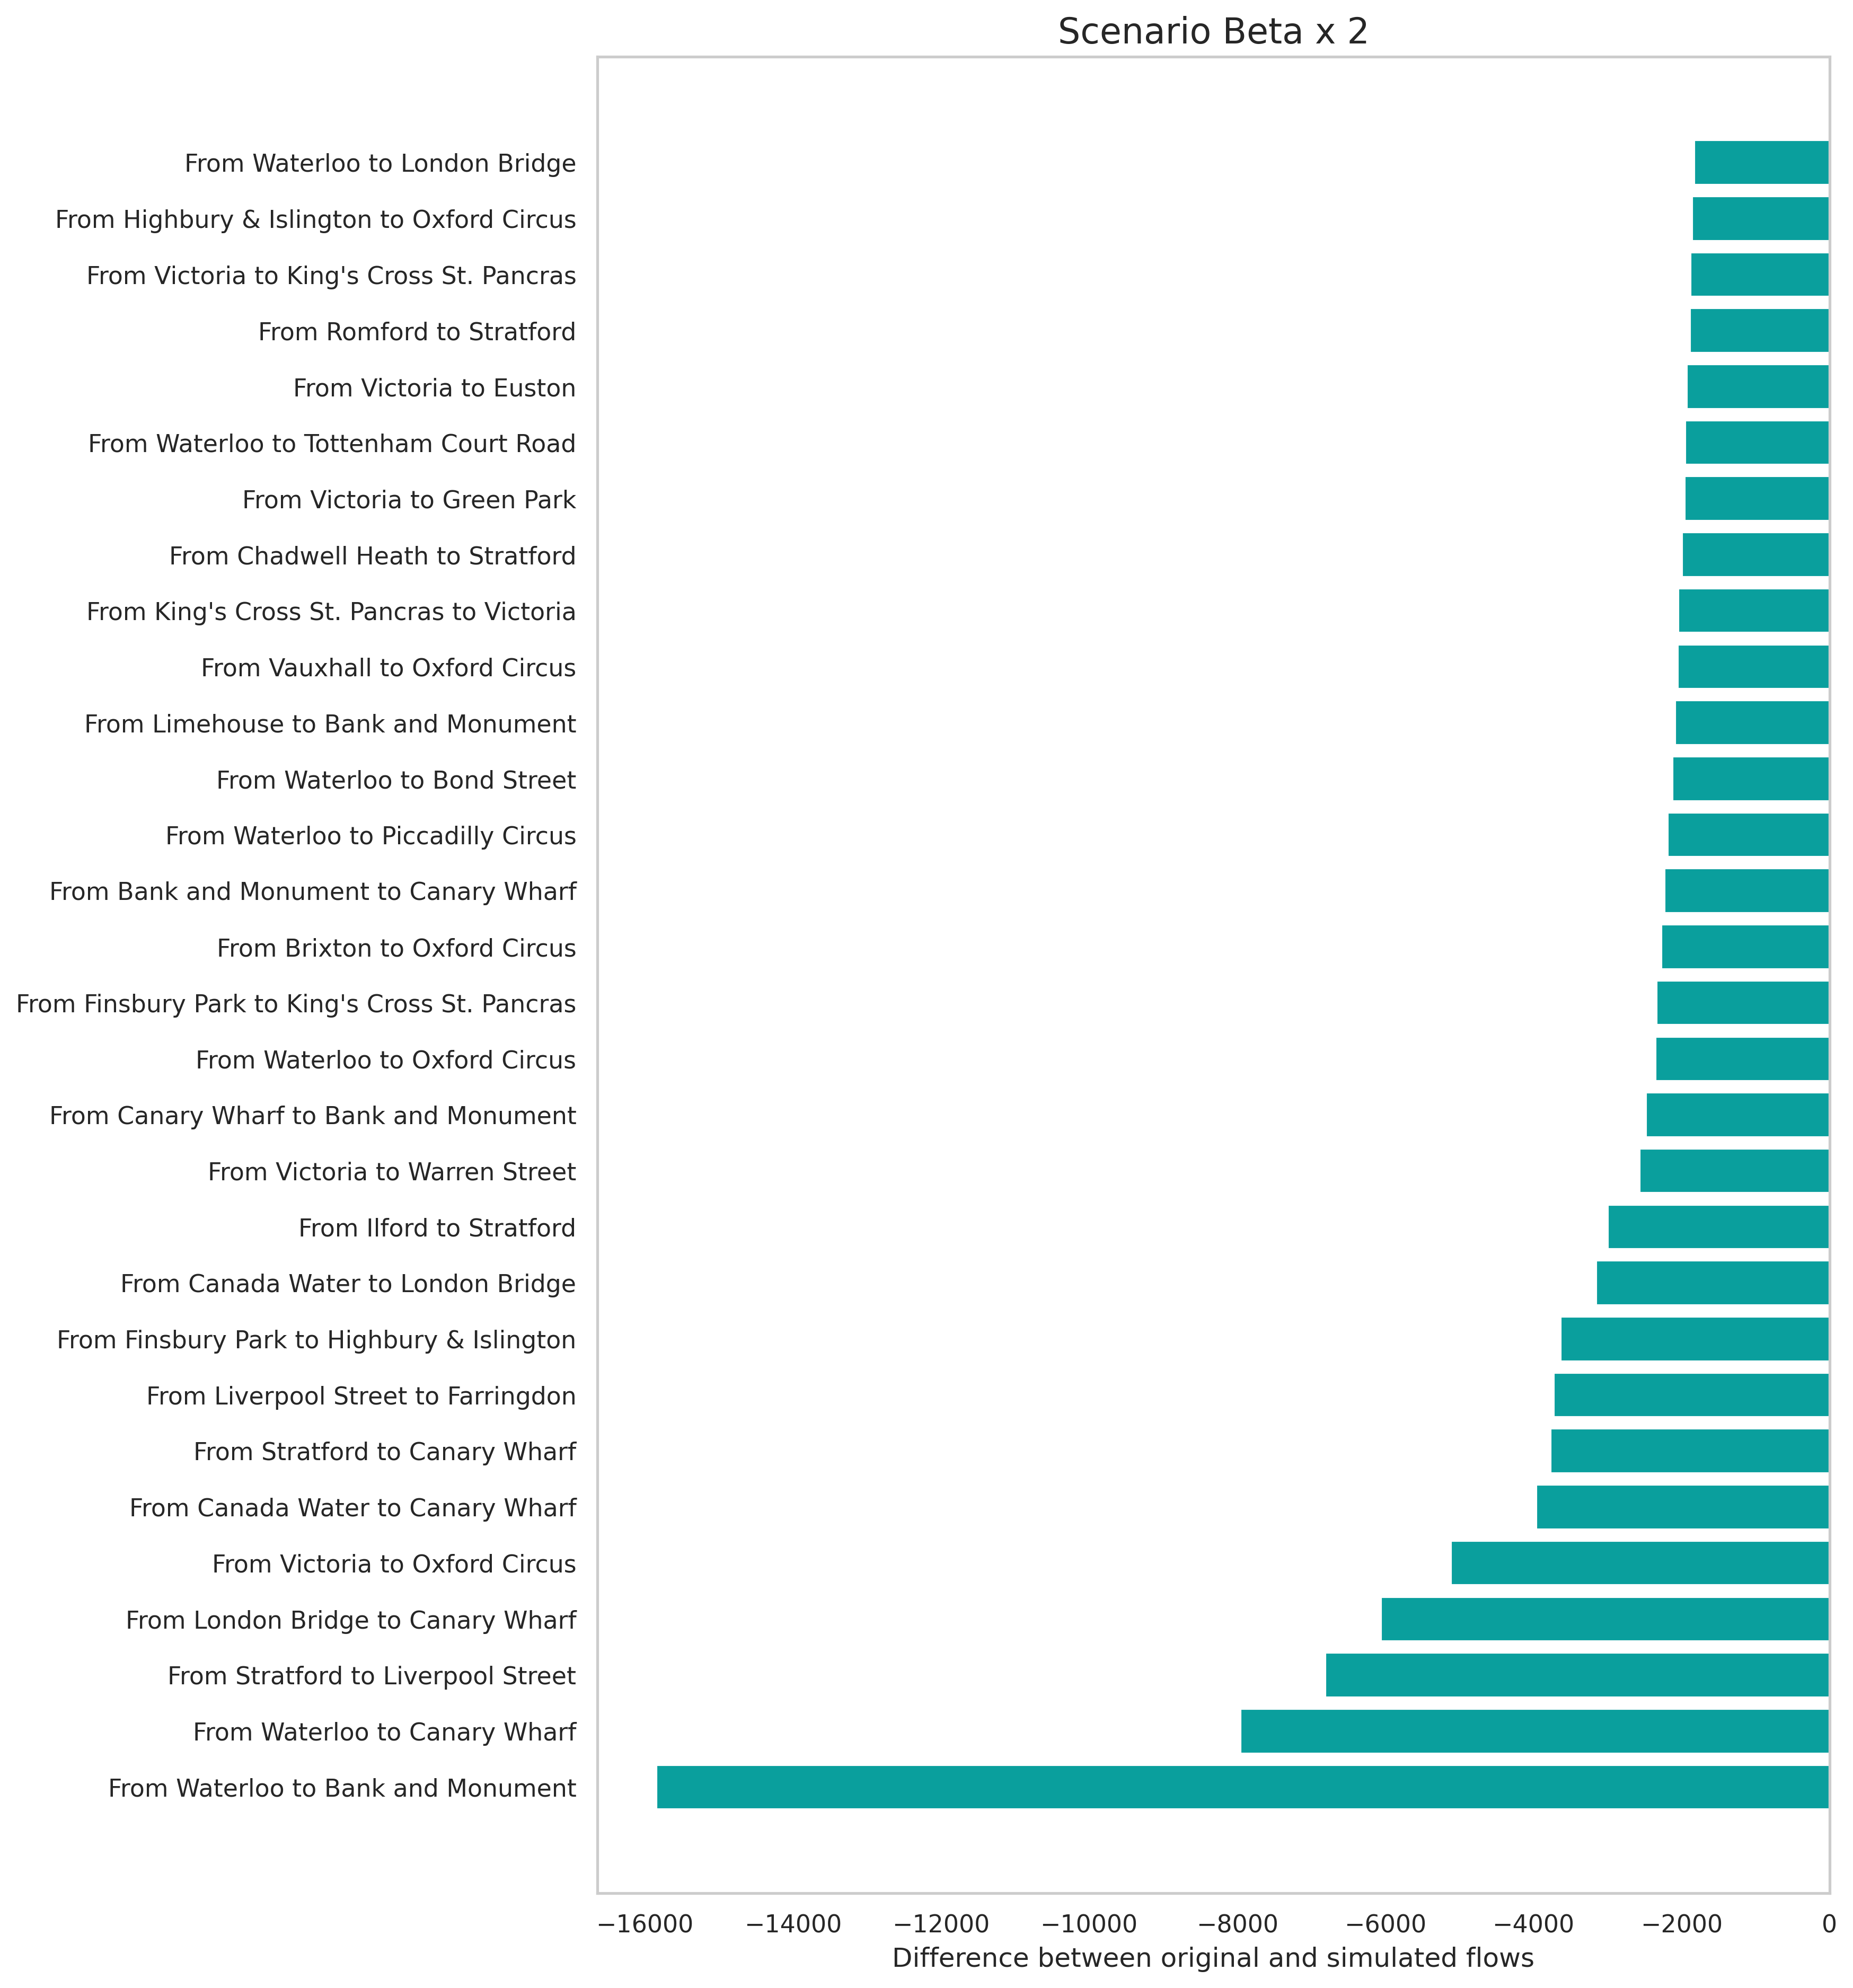

In [343]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your setup code
plt.figure(figsize=(10, 15), dpi=300)
sns.set_theme(style='whitegrid')

o_d_ = []
sc_df_plot = sc_df.sort_values('abs_diff_B2', ascending=False).reset_index()
sc_df_plot = sc_df_plot.drop(columns='index')

# Generating your bar labels
for i in range(30):
    o_d_.append('From ' + sc_df_plot.iloc[i, 0] + ' to ' + sc_df_plot.iloc[i, 1])

plt.barh(o_d_, sc_df_plot.loc[:29, 'diff_B2'], color=asteroid_city_col[0])

# Turn off gridlines for the current axis
plt.grid(False)  # This will turn off gridlines

plt.title('Scenario Beta x 2', fontsize=16)
plt.xlabel('Difference between original and simulated flows', fontsize=12)

# If you want to save the figure
# plt.savefig('Output/Figure_scenario_A.png', dpi=300, bbox_inches='tight')

plt.show()

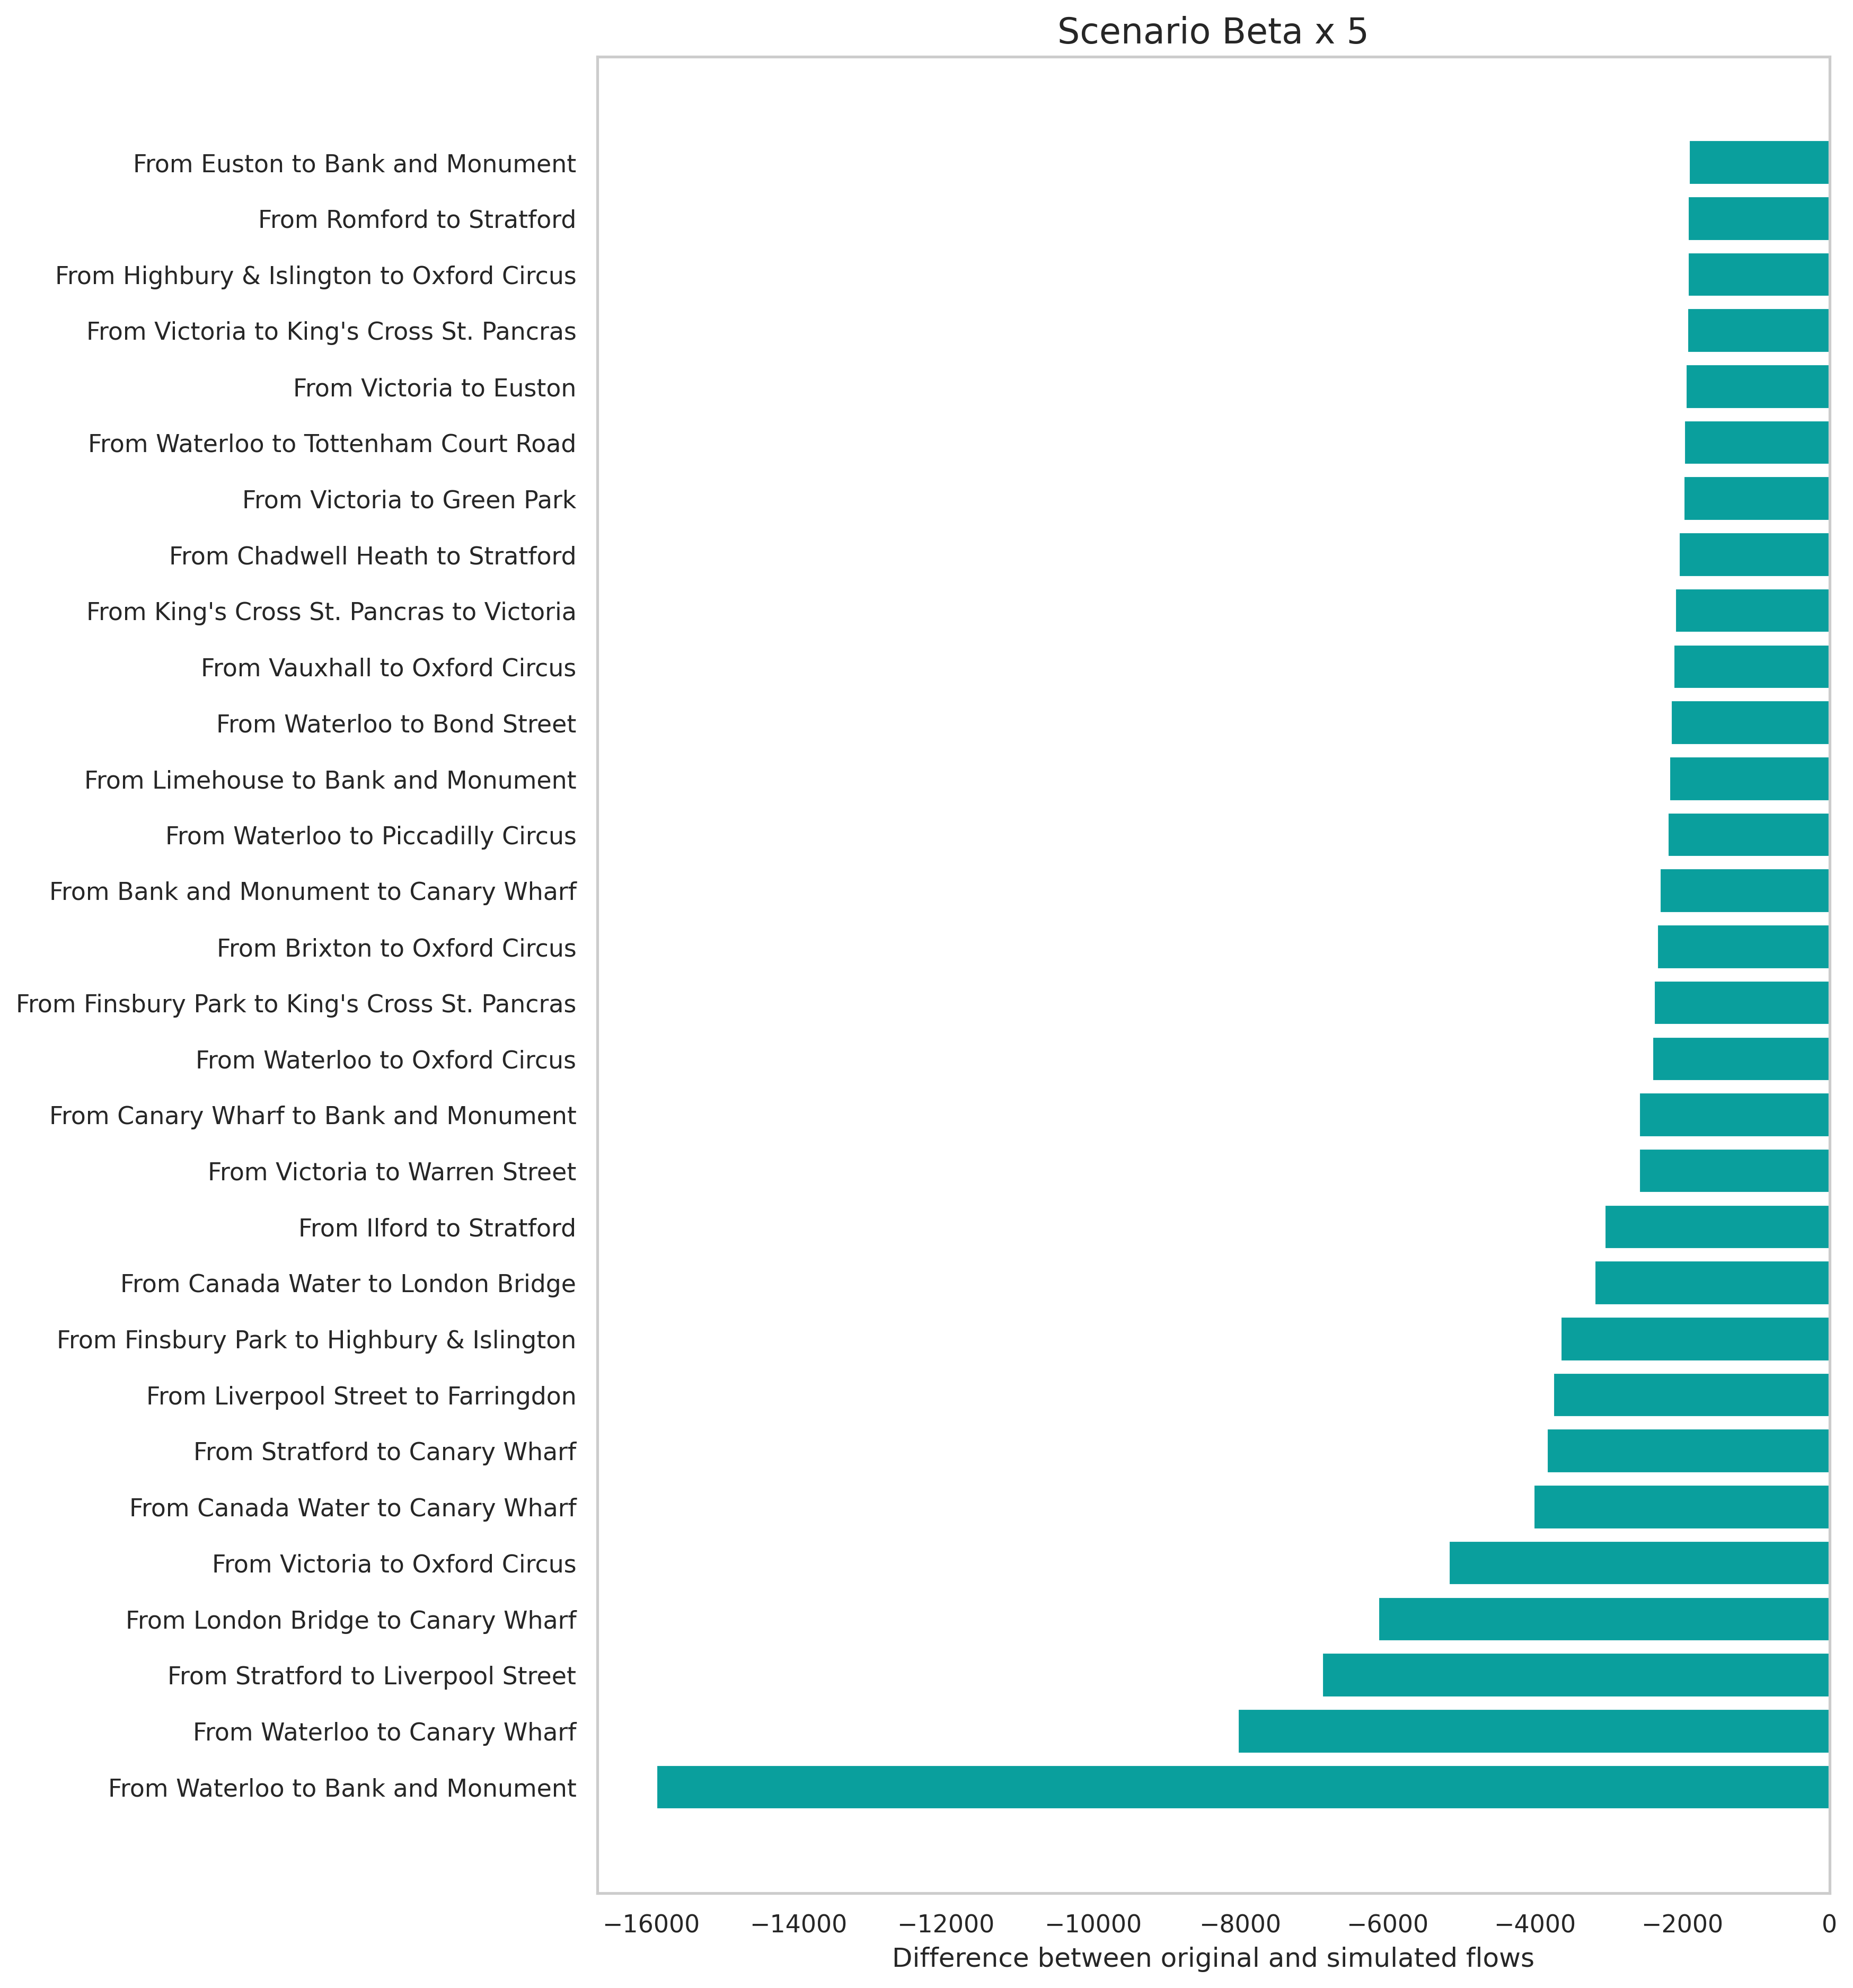

In [342]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your setup code
plt.figure(figsize=(10, 15), dpi=300)
sns.set_theme(style='whitegrid')

o_d_ = []
sc_df_plot = sc_df.sort_values('abs_diff_B5', ascending=False).reset_index()
sc_df_plot = sc_df_plot.drop(columns='index')

# Generating your bar labels
for i in range(30):
    o_d_.append('From ' + sc_df_plot.iloc[i, 0] + ' to ' + sc_df_plot.iloc[i, 1])

plt.barh(o_d_, sc_df_plot.loc[:29, 'diff_B5'], color=asteroid_city_col[0])

# Turn off gridlines for the current axis
plt.grid(False)  # This will turn off gridlines

plt.title('Scenario Beta x 5', fontsize=16)
plt.xlabel('Difference between original and simulated flows', fontsize=12)

# If you want to save the figure
# plt.savefig('Output/Figure_scenario_A.png', dpi=300, bbox_inches='tight')

plt.show()

<Figure size 640x480 with 0 Axes>

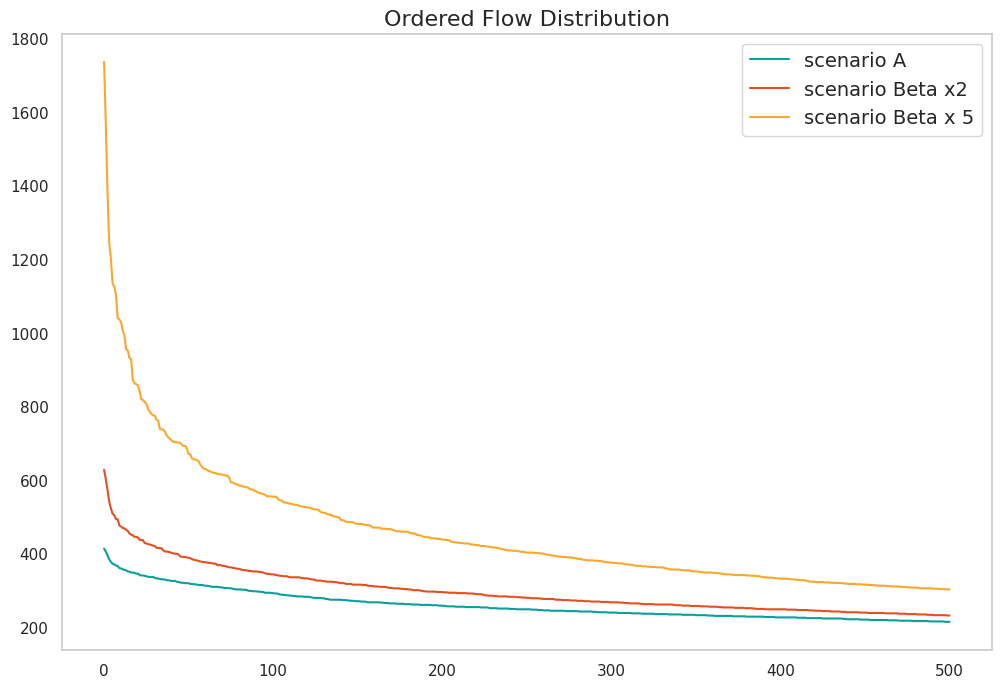

In [349]:
plt.figure()
fig, ax = plt.subplots(figsize=(12,8))

sc_plot = sc_df.sort_values('attrsimest4',ascending=False).reset_index()
sc_plot = sc_plot.drop(columns='index')
ax.plot(sc_plot.loc[:500,'attrsimest4'],label='scenario A',color=asteroid_city_col[0])

df_B2_result = sc_df.sort_values('attrsimestB2',ascending=False).reset_index()
df_B2_result = df_B2_result.drop(columns='index')
x_pt = np.arange(0,len(df_B2_result))
ax.plot(df_B2_result.loc[:500,'attrsimestB2'],label='scenario Beta x2',color=asteroid_city_col[2])

df_B5_result = sc_df.sort_values('attrsimestB5',ascending=False).reset_index()
df_B5_result = df_B5_result.drop(columns='index')
ax.plot(df_B5_result.loc[:500,'attrsimestB5'],label='scenario Beta x 5',color=asteroid_city_col[11])

ax.grid(False)

plt.title('Ordered Flow Distribution', fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [ ]:
#calculate some new Oi^alpha and d_ij^beta values
#called oi2_alpha and dist_beta
Oi2_alpha = cdatasub["Oi1_origpop"]**alpha
dist_beta = cdatasub["Dist"]**-beta

#calcualte the first stage of the Bj values
cdatasub["Bj1"] = Oi2_alpha * dist_beta

#now do the sum over all is bit
B_j = pd.DataFrame(cdatasub.groupby(["DestCodeNew"])["Bj1"].agg(np.sum))

#now divide into 1
B_j["Bj1"] = 1/B_j["Bj1"]

#rename the column from Bj1 to B_j
B_j.rename(columns={"Bj1":"B_j2"}, inplace=True)
#and write the B_j values back into the dataframe
cdatasub = cdatasub.merge(B_j, left_on="DestCodeNew", right_index=True, how="left")

In [ ]:
#to check that everything works, recreate the original estimates
#using equation 5 above and assign to attrsimest3
cdatasub["attrsimest3"] = cdatasub["B_j2"]*cdatasub["D_j"]*Oi2_alpha * dist_beta

#round
cdatasub["attrsimest3"] = round(cdatasub["attrsimest3"])
#check the head of the results
cdatasub[["attrsimFitted","attrsimest3"]].head()

In [ ]:
#calculate some new O_i^alpha 
#call it Oi3_alpha
Oi3_alpha = cdatasub["Oi2_origpopScenario"]**alpha

#calculate the first stage of the Bj values
cdatasub["Bj1"] = Oi3_alpha * dist_beta
#now do the sum over all is bit
B_j = pd.DataFrame(cdatasub.groupby(["DestCodeNew"])["Bj1"].agg(np.sum))
#now divide into 1
B_j["Bj1"] = 1/B_j["Bj1"]
#rename the column
B_j.rename(columns={"Bj1":"Bj2"}, inplace=True)
#and write the B_j values back into the dataframe
cdatasub = cdatasub.merge(B_j, left_on="DestCodeNew", right_index=True, how="left")

In [ ]:
cdatasub["attrsimest4"] = cdatasub["Bj2"]*cdatasub["D_j"]*Oi3_alpha * dist_beta
#round to integer values
cdatasub["attrsimest4"] = round(cdatasub["attrsimest4"])

In [ ]:
cdatasubmat8 = cdatasub.pivot_table(values ="attrsimest4", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)

#show the matrix
cdatasubmat8

In [ ]:
#set out all the fomrulas
formula1 = "Total ~ np.log(Oi1_origpop) + np.log(Dj2_destsal) + np.log(Dist) -1"
formula2 = "Total ~ OrigCodeNew + np.log(Dj2_destsal) + np.log(Dist) -1"
formula3 = "Total ~ np.log(Oi1_origpop) + DestCodeNew + np.log(Dist) -1"
formula4 = "Total ~ OrigCodeNew + DestCodeNew + np.log(Dist) -1"
formula5 = "Total ~ np.log(Oi1_origpop) + np.log(Dj2_destsal) + Dist -1"
formula6 = "Total ~ OrigCodeNew + np.log(Dj2_destsal) + Dist -1"
formula7 = "Total ~ np.log(Oi1_origpop) + DestCodeNew + Dist -1"
formula8 = "Total ~ OrigCodeNew + DestCodeNew + Dist -1"

#create a list of all the formulas
formulas = [formula1, formula2, formula3, formula4, 
            formula5, formula6, formula7, formula8]

#list the models name
models = ["uncosim_pow", "prodsim_pow", "attrsim_pow", "doublesim_pow",
         "uncosim_exp", "prodsim_exp", "attrsim_exp", "doublesim_exp"]

#create a set of tuples to store whether a paramater
#will be in the model or not
model_params = [(True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True),
               (True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True)]

#create an ampty dictionary to store the results
results = {"Model":models,
          "R2": [],
          "RMSE": [],
          "Alpha":[],
          "Gamma":[],
          "Beta":[]}

#loop over each formula
for i, formula in enumerate(formulas):
    
    #run the specified model
    sim = smf.glm(formula = formula, 
                 data = cdata,
                 family = sm.families.Poisson()).fit()
    #clauclate the estimates
    cdata[models[i]] = sim.mu
    
    #if the alpha paramater is true
    if model_params[i][0] == True:
        
        #if there are three params then it will be 
        #in the third position
        if sum(model_params[i]) == 3:
            
            results["Alpha"].append(sim.params[-3])
            
        #otherwise it will be in the second paramater
        else:
            results["Alpha"].append(sim.params[-2])
            
    #if not then just append nan
    else:
        results["Alpha"].append(np.nan) 
    
    #if the gamma paramater is True
    #then it will always be the second paramater
    if model_params[i][1] == True:
        results["Gamma"].append(sim.params[-2])
    #otherwise add nan
    else:
        results["Gamma"].append(np.nan)
    
    #add the beta to the results (always will be there)
    results["Beta"].append(sim.params[-1])
        
    #add the metrics to the results dictionary
    results["R2"].append(CalcRSqaured(cdata["Total"],cdata[models[i]]))
    results["RMSE"].append(CalcRMSE(cdata["Total"],cdata[models[i]]))

#create a dataframe from the results
results = pd.DataFrame(results)
#print the results
results